# VAR Model

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import warnings
import matplotlib.ticker as ticker

In [ ]:
with open('../sql-scripts/var.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
var_df = pd.read_sql_query(sql_script, conn)
conn.close()

    neighborhood  year    zillow   income  unemployment  distance  duration
0    Azalea Park  2011  66506.14 41168.00          0.14     20.10     24.00
1    Azalea Park  2012  65765.40 38423.00          0.15     20.10     24.00
2    Azalea Park  2013  80992.40 31667.00          0.13     20.10     24.00
3    Azalea Park  2014 101463.24 34977.00          0.10     20.10     24.00
4    Azalea Park  2015 116724.24 37106.00          0.09     20.10     24.00
..           ...   ...       ...      ...           ...       ...       ...
493    Windhover  2017  95167.33 36596.00          0.08      8.90     14.00
494    Windhover  2018 111859.98 36678.00          0.06      8.90     14.00
495    Windhover  2019 128637.33 35560.00          0.04      8.90     14.00
496    Windhover  2020 138929.26 40720.00          0.04      8.90     14.00
497    Windhover  2021 150404.85 43250.00          0.04      8.90     14.00

[498 rows x 7 columns]


## Fit the model

In [189]:
# Container to store VAR results for each neighborhood
grouped_results = {}

# Group the data by neighborhood
for neighborhood, group_df in var_df.groupby("neighborhood"):
  # Drop the 'neighborhood', 'distance', and 'duration' columns as they're not used in the VAR model
  group_df = group_df.drop(columns=["neighborhood", "distance", "duration"])
  
  # Ensure the data is sorted by index (if applicable)
  group_df = group_df.sort_index()
  
  # Apply second differencing
  group_df = group_df.diff().diff().dropna()

  # Check if enough data points are available after differencing
  if len(group_df) <= 1:  # At least 2 data points needed for lag 1
    print(f"Skipping {neighborhood} due to insufficient data after differencing.")
    continue
  
  # Fit the VAR model, automatically determining the maximum lag
  model = VAR(group_df)
  
  # Try fitting with a different method to handle potential singularity
      # Using 'aic' to select the lag order that minimizes the AIC
  results = model.fit() 
  
  # Store the results
  grouped_results[neighborhood] = results

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

Skipping Beltway Commerce Center due to insufficient data after differencing.
Skipping City of Orlando/GOAA due to insufficient data after differencing.
Skipping Colonial Town Center due to insufficient data after differencing.
Skipping Countryside due to insufficient data after differencing.
Skipping Lake Davis/Greenwood due to insufficient data after differencing.
Skipping Lake Dot due to insufficient data after differencing.
Skipping Lake Fairview due to insufficient data after differencing.
Skipping Lake Fredrica due to insufficient data after differencing.
Skipping Lake Holden due to insufficient data after differencing.
Skipping New Malibu due to insufficient data after differencing.
Skipping Pershing due to insufficient data after differencing.
Skipping South Division due to insufficient data after differencing.
Skipping Vista Park due to insufficient data after differencing.


## Forecast for the next 5 periods

In [175]:
# Forecast home prices for each neighborhood for the next 10 years
forecast_results = {}

for neighborhood, results in grouped_results.items():
  # Generate forecasts for the next 10 periods (years)
  forecast_steps = 8
  forecast = results.forecast(results.endog[-results.k_ar:], steps=forecast_steps)

  # Create a DataFrame to display the forecast results
  forecast_df = pd.DataFrame(forecast, columns=results.names, index=range(2022, 2022 + forecast_steps))
  forecast_results[neighborhood] = forecast_df

# Create a DataFrame to store the forecasted Zillow values for each neighborhood
forecast_horizon_df = pd.DataFrame()

# Loop through each neighborhood in forecast_horizon_df
for neighborhood, forecast_df in forecast_results.items():
  # Retrieve the last two actual home prices from var_df for the current neighborhood
  neighborhood_data = var_df[var_df["neighborhood"] == neighborhood].sort_values("year")
  hp_2020 = neighborhood_data.iloc[-2]["zillow"]
  hp_2021 = neighborhood_data.iloc[-1]["zillow"]

  # Step 1: Start with known values
  first_diff_2021 = hp_2021 - hp_2020

  # Step 2: Forecasted second differences
  second_diffs = forecast_df["zillow"].values

  # Step 3: Reconstruct first differences
  first_diffs = [first_diff_2021]
  for second_diff in second_diffs:
    next_diff = first_diffs[-1] + second_diff
    first_diffs.append(next_diff)

  # Step 4: Reconstruct home prices
  home_prices = [hp_2021]  # starting from 2021
  for first_diff in first_diffs:
    next_price = home_prices[-1] + first_diff
    home_prices.append(next_price)

  # Step 5: Add the forecasted home prices to the DataFrame
  years = list(range(2022, 2022 + len(home_prices) - 1))  # 2022 onwards
  forecast_horizon_df[neighborhood] = home_prices[1:]  # Exclude the starting value

# Transpose the DataFrame for better readability
forecast_horizon_df = forecast_horizon_df.T
forecast_horizon_df.columns = range(2022, 2022 + forecast_horizon_df.shape[1])

# Display the top 10 rows of the sorted DataFrame
print(forecast_horizon_df.sort_values(by=2030, ascending=False).head(10))

                        2022      2023      2024      2025      2026  \
Southern Oaks      633371.33 648847.45 739895.30 744812.17 869211.36   
Orwin Manor        696225.43 724550.60 788301.65 839209.35 888248.23   
Rowena Gardens     578280.20 616091.99 667420.02 716344.55 763161.55   
The Willows        162431.89 169120.00 203605.30 190344.25 276635.23   
Wedgewood Groves   335178.78 337003.08 383913.64 359190.41 453692.47   
Colonialtown North 403531.10 434542.03 474414.32 508846.83 549235.78   
Crescent Park      420642.87 441126.39 478498.44 506745.50 543814.64   
Bryn Mawr          324020.48 360461.24 398521.03 440162.86 483657.90   
Baldwin Park       617768.00 620643.68 638184.56 646784.67 663289.39   
College Park       447869.57 473402.42 503629.30 528739.77 557377.25   

                        2027       2028       2029       2030  
Southern Oaks      851619.10 1024354.86  965025.65 1210518.50  
Orwin Manor        956432.39 1003943.46 1073868.42 1132802.12  
Rowena Gardens 

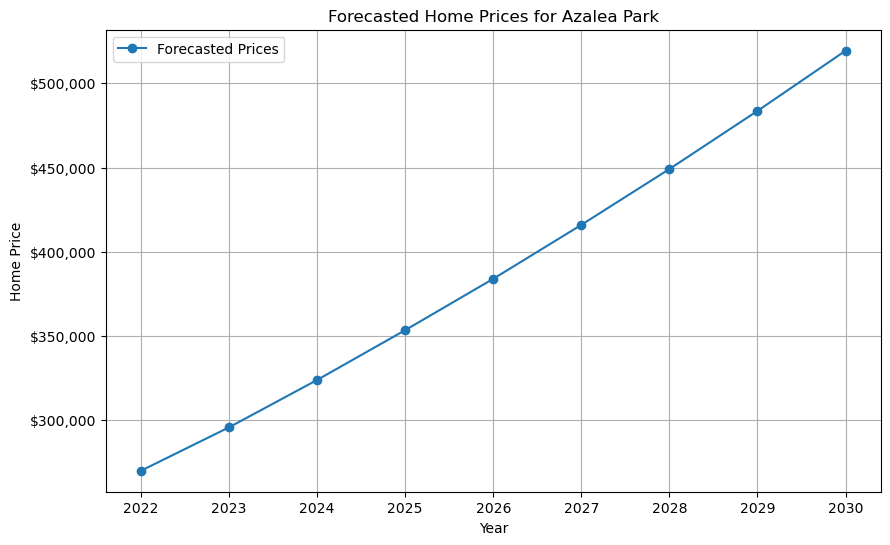

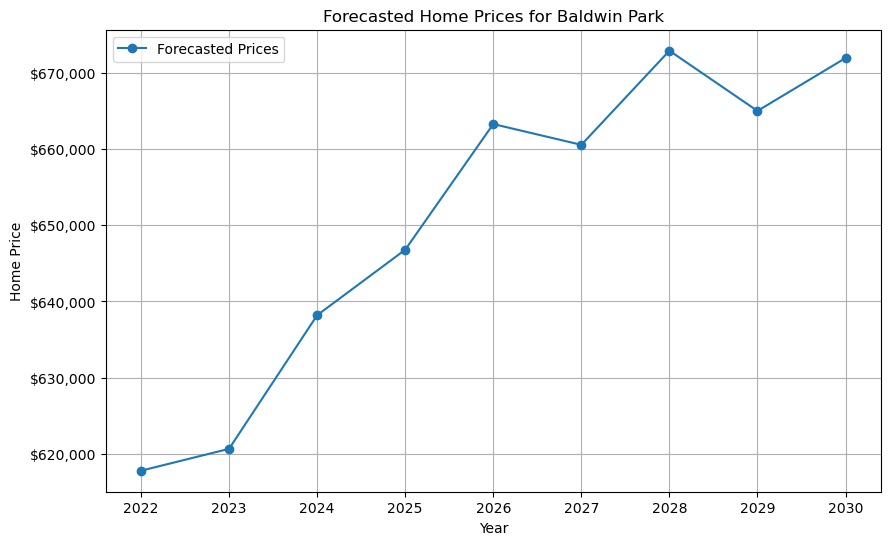

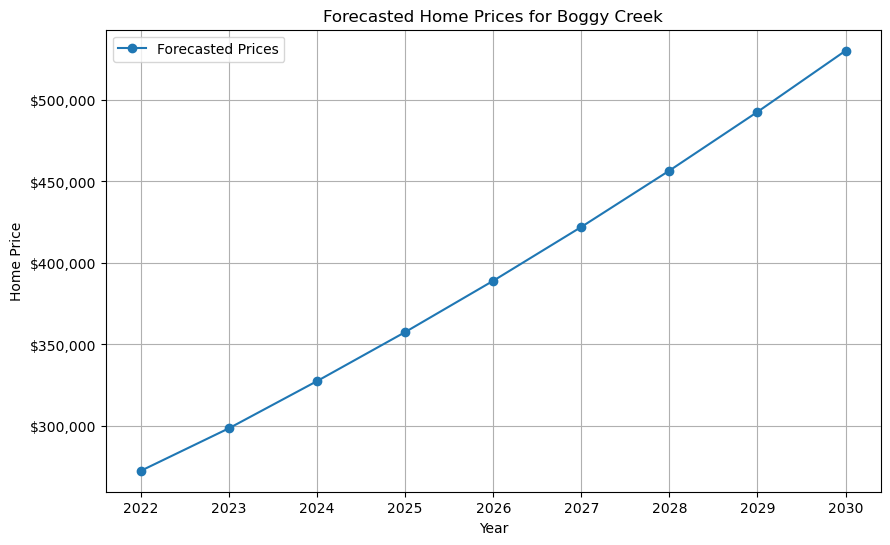

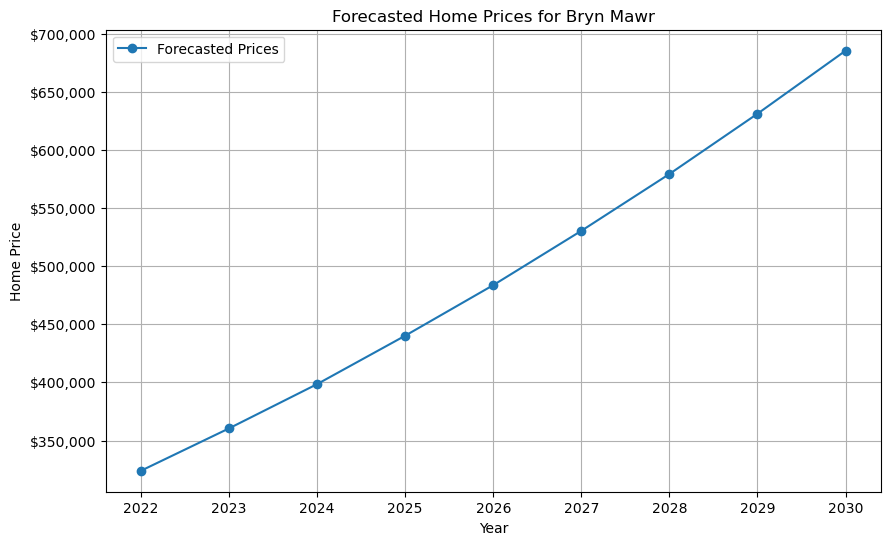

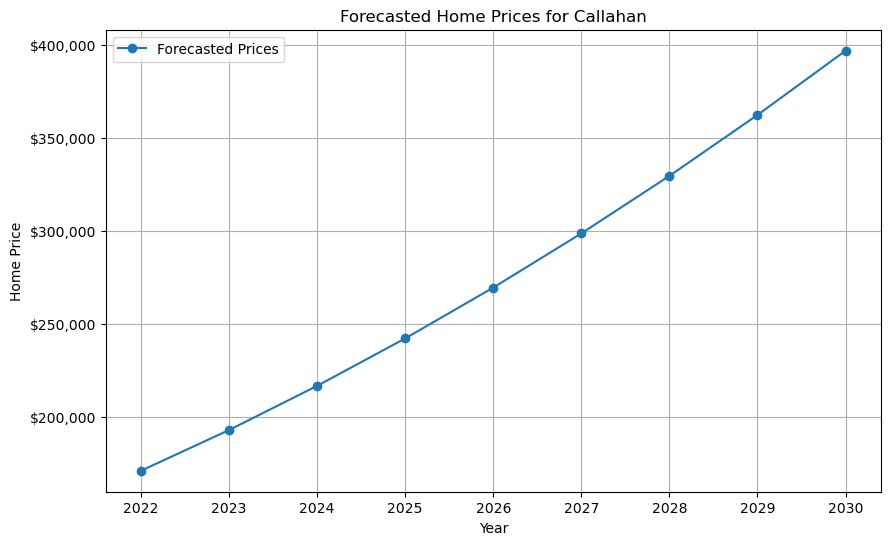

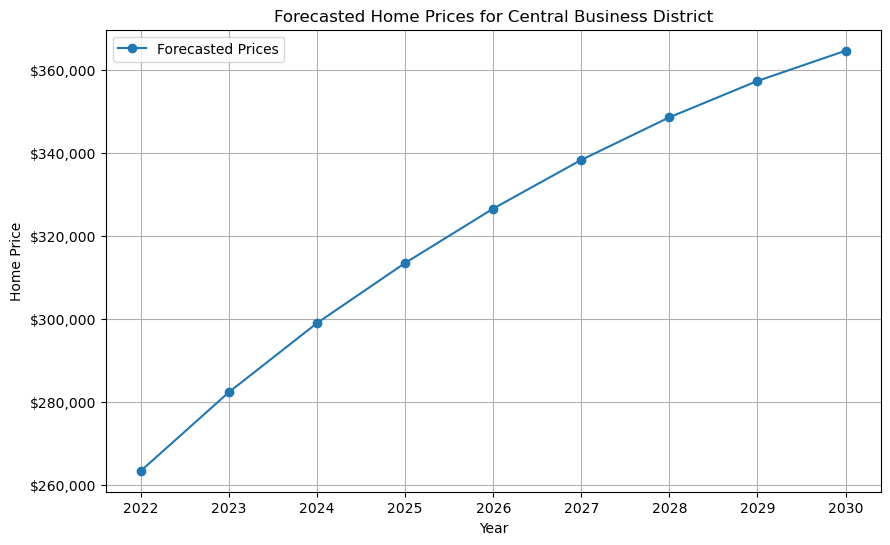

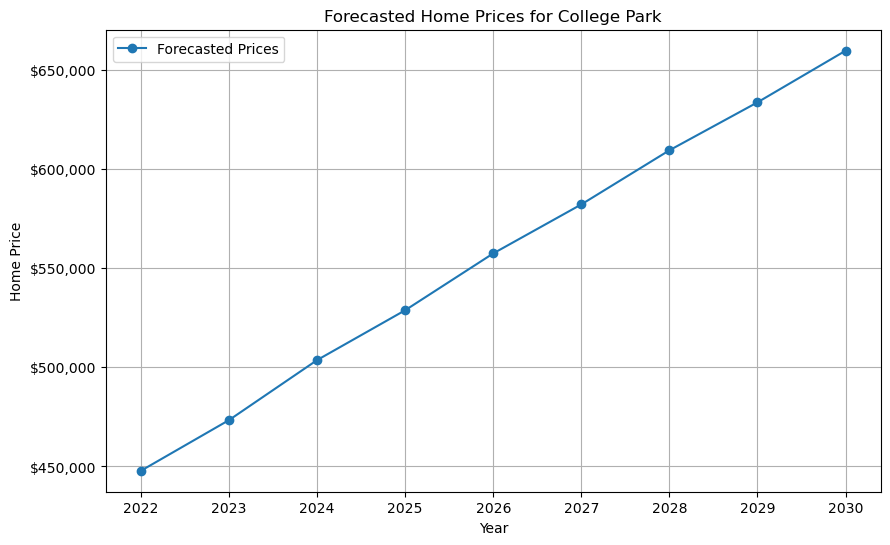

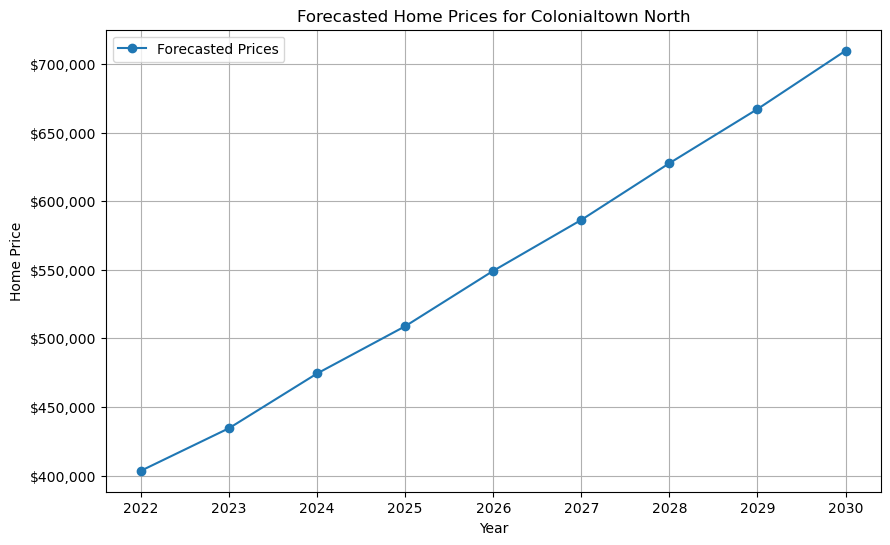

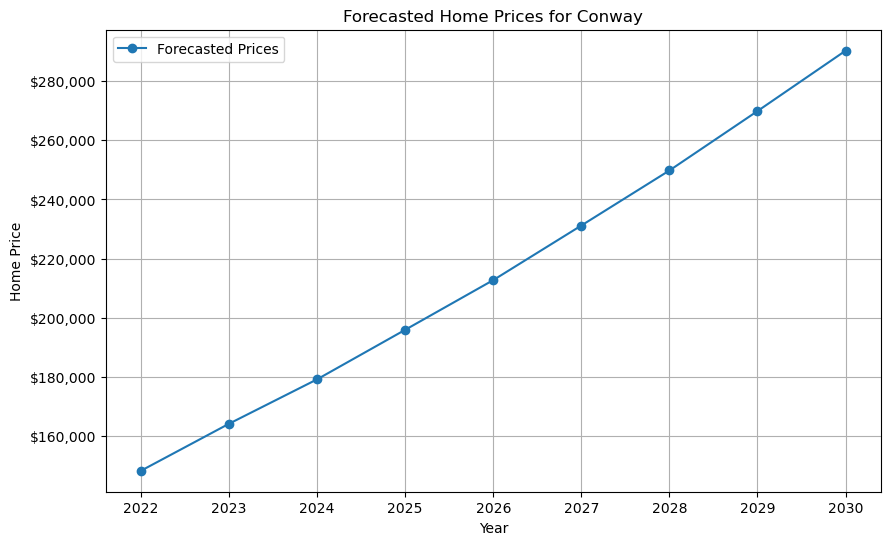

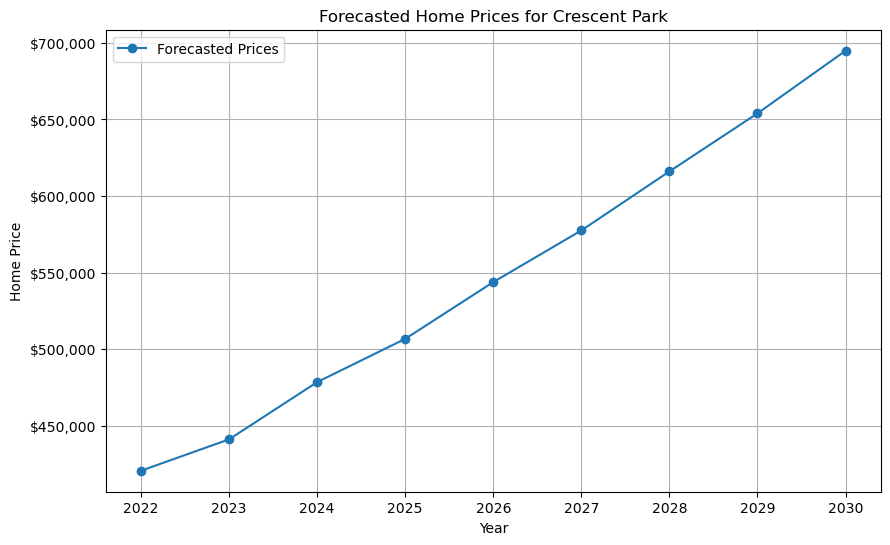

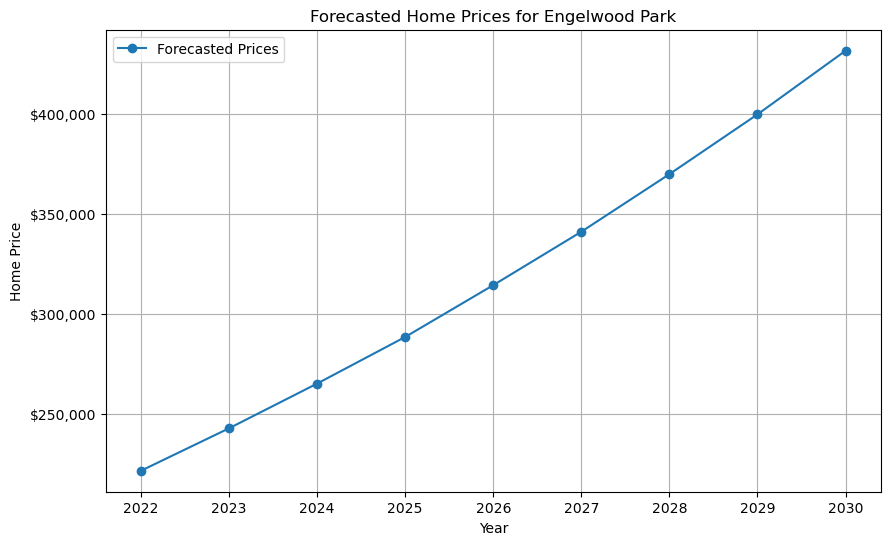

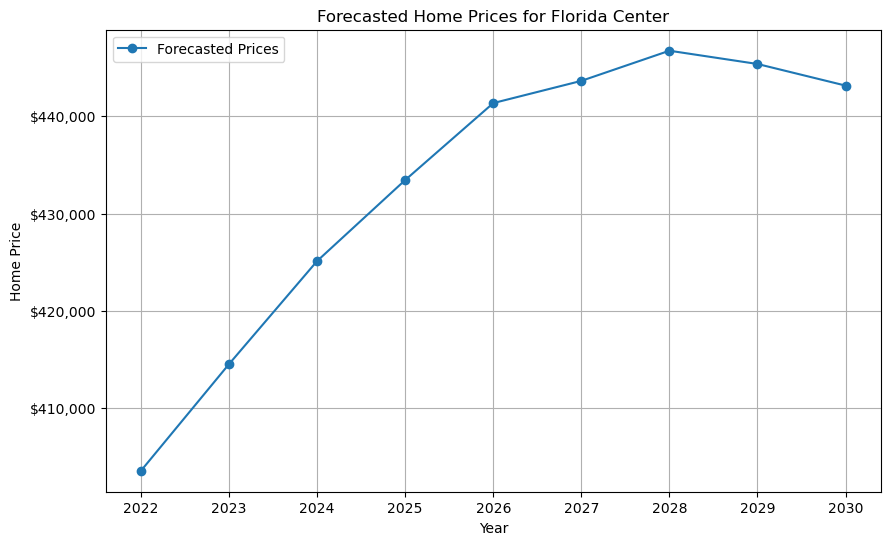

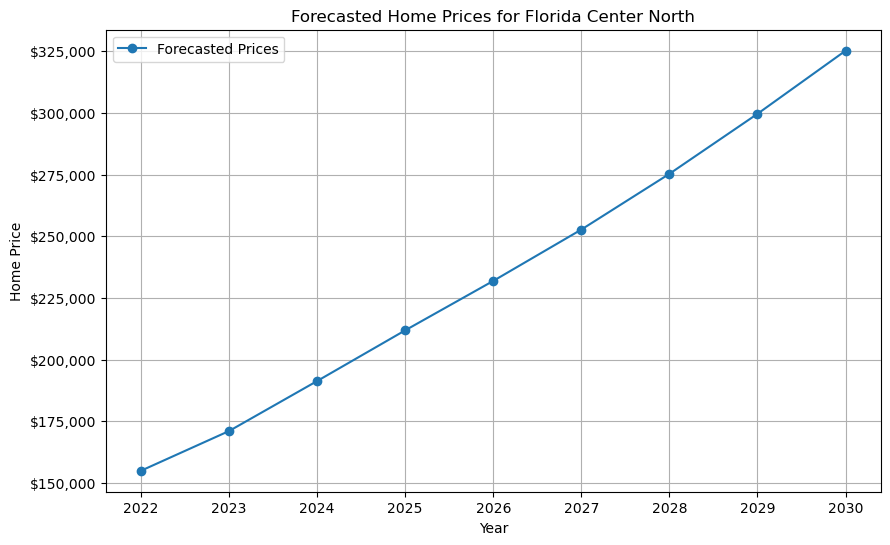

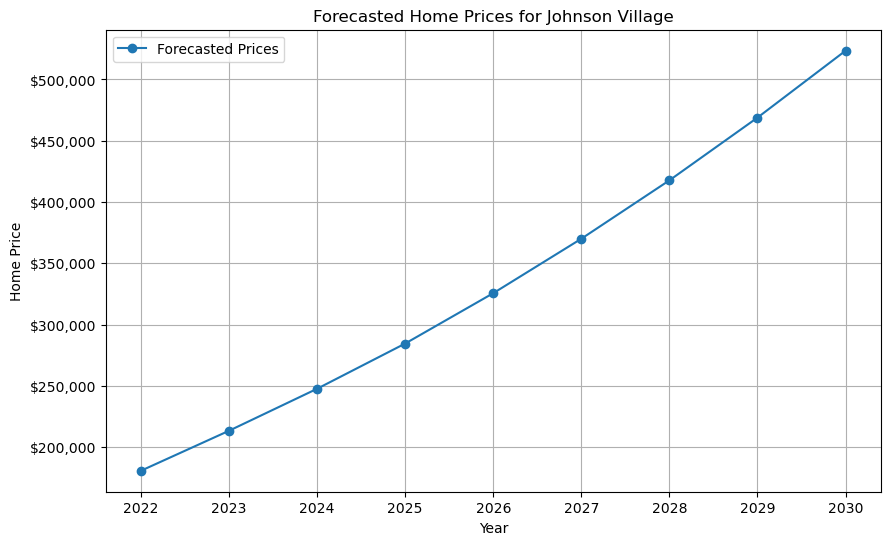

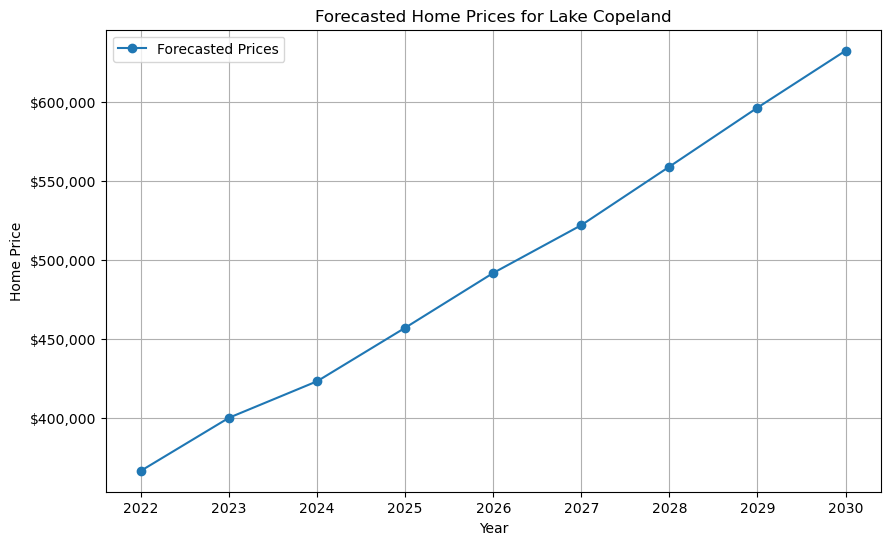

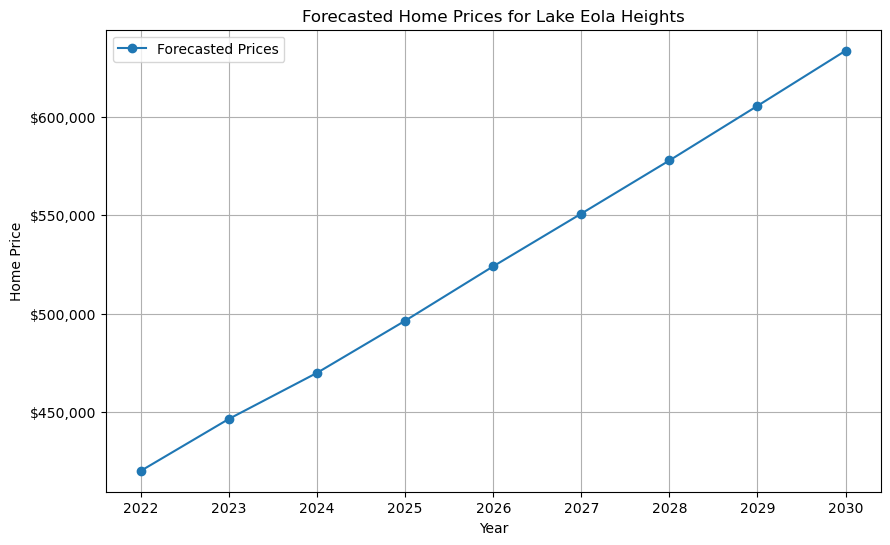

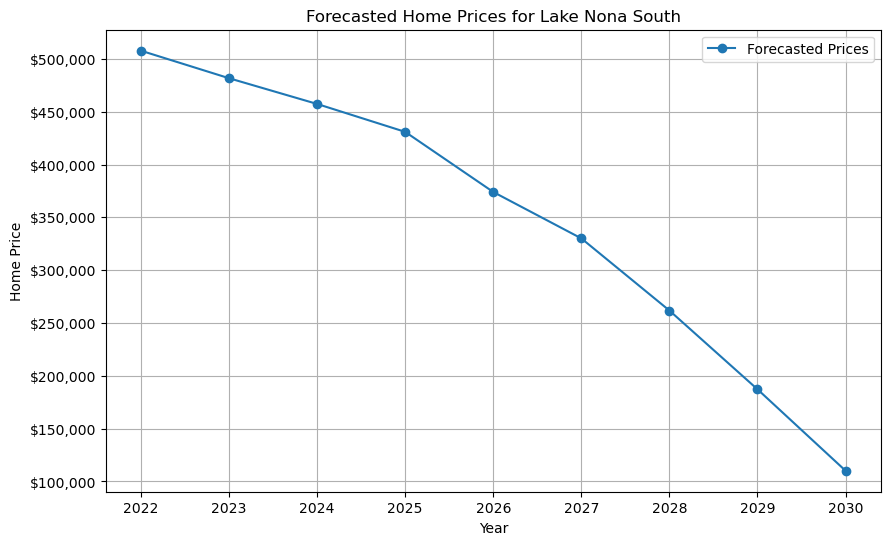

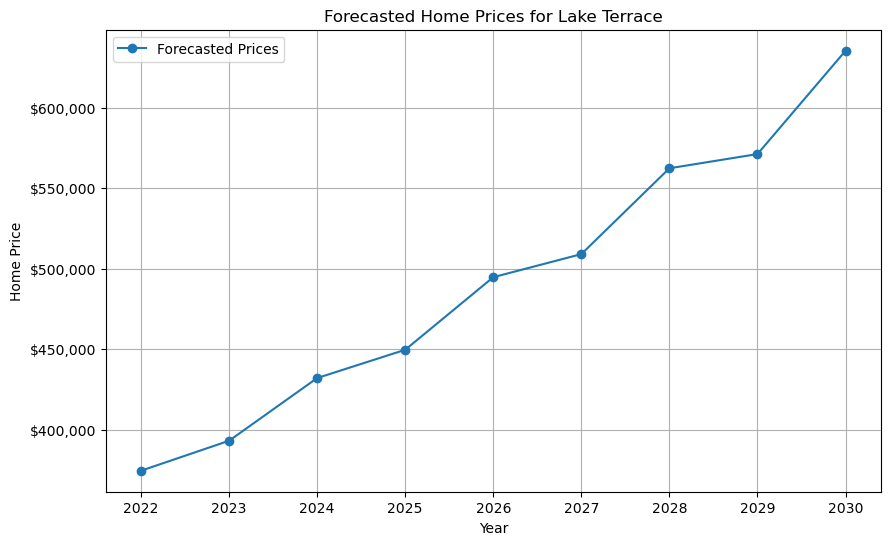

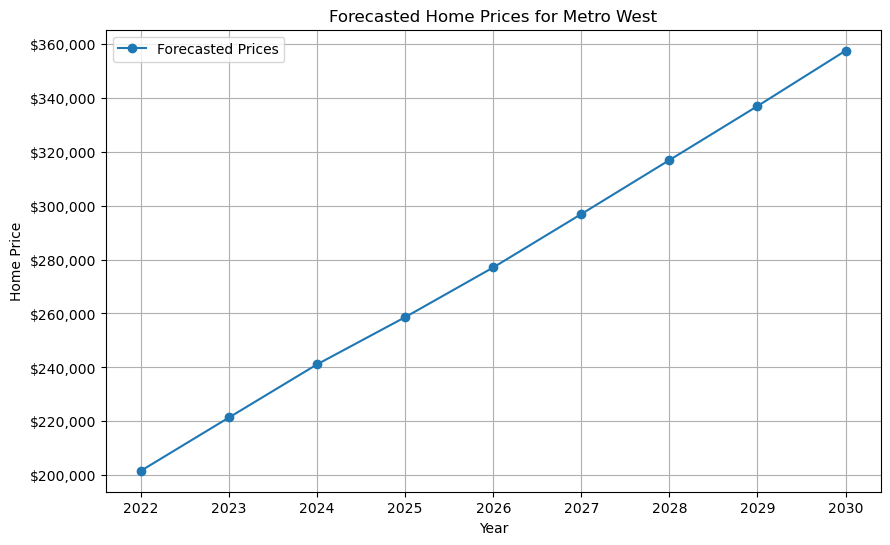

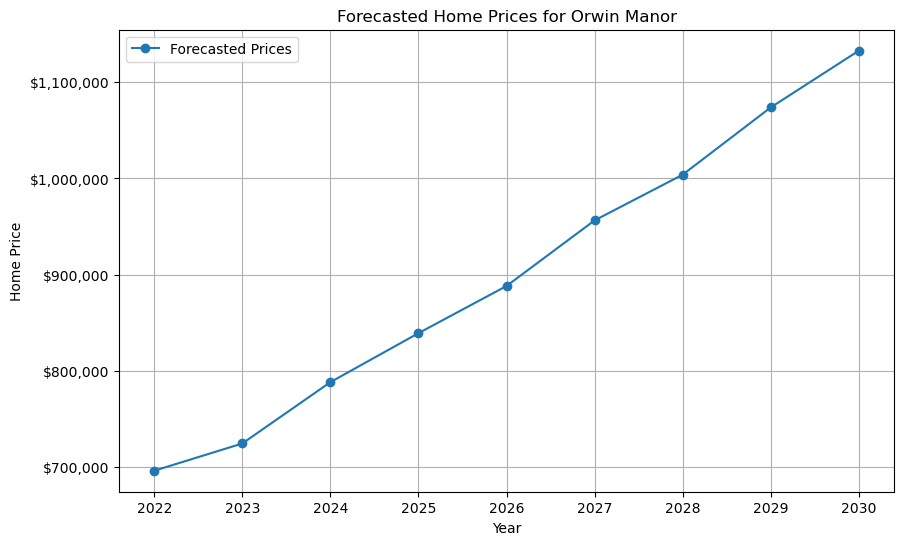

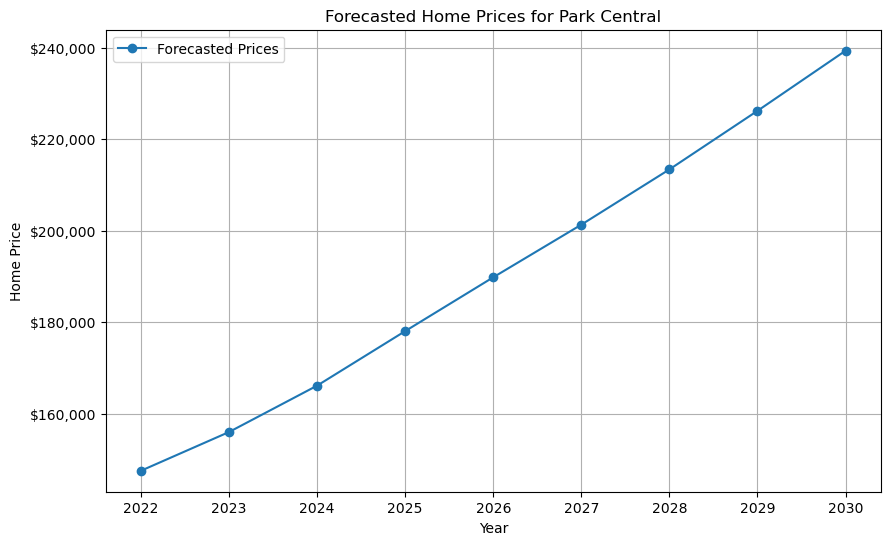

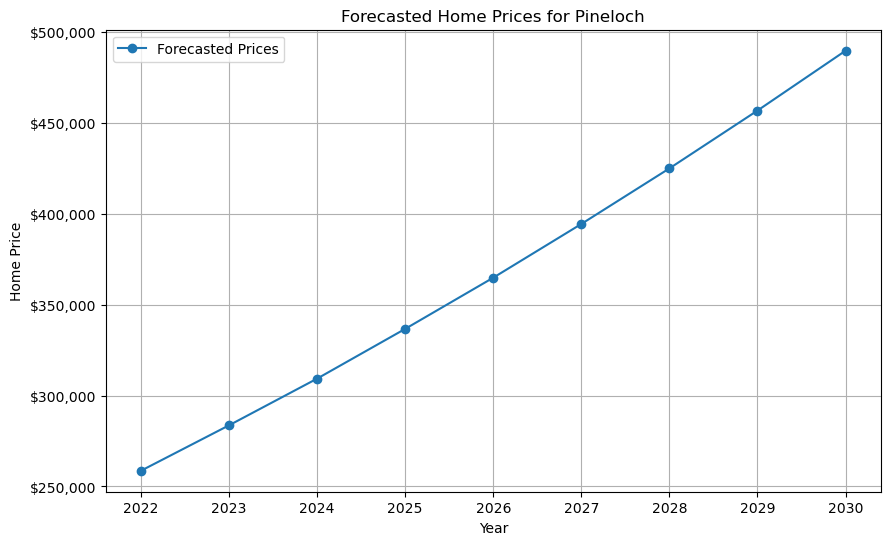

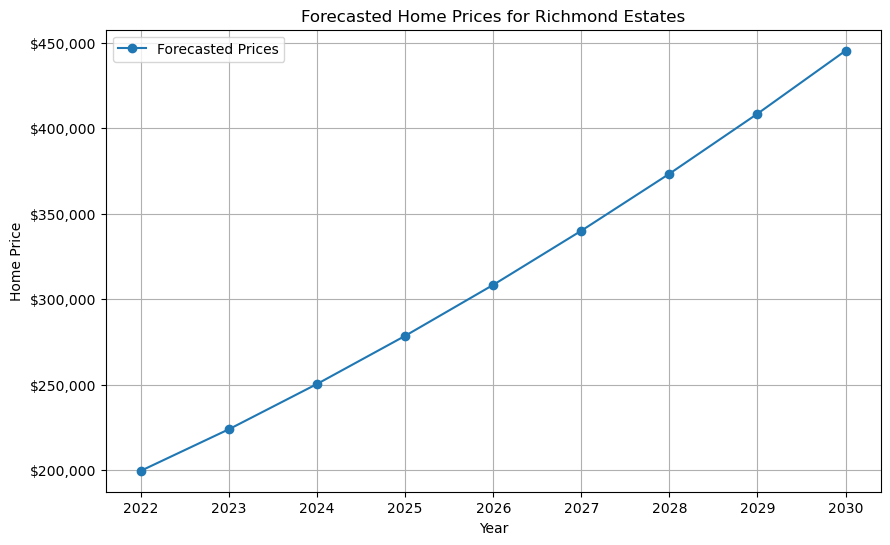

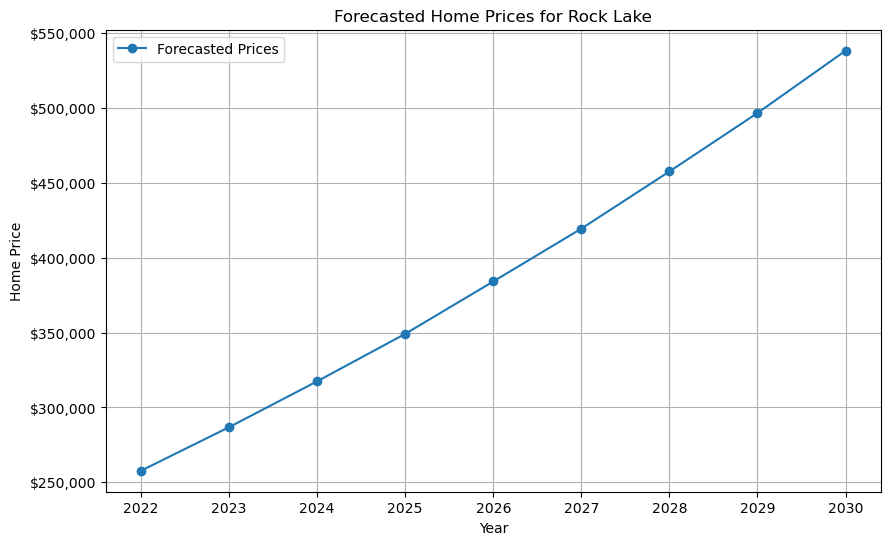

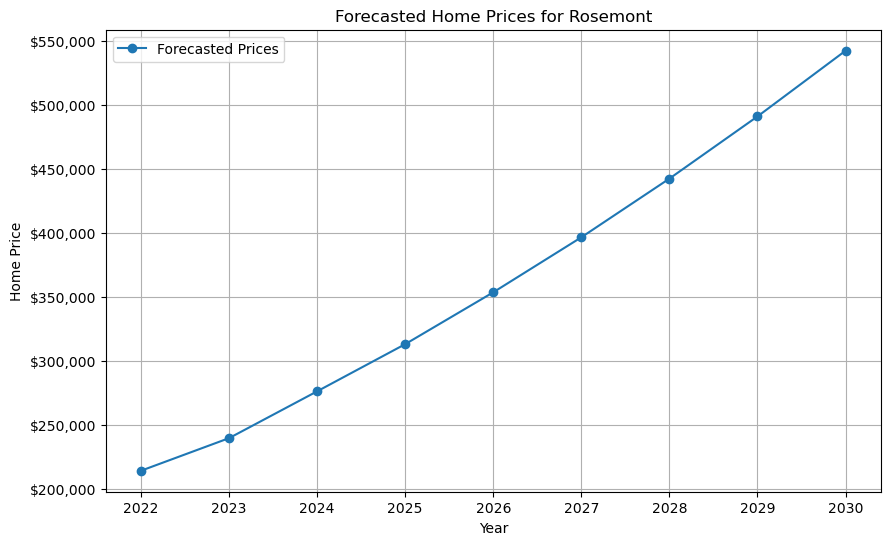

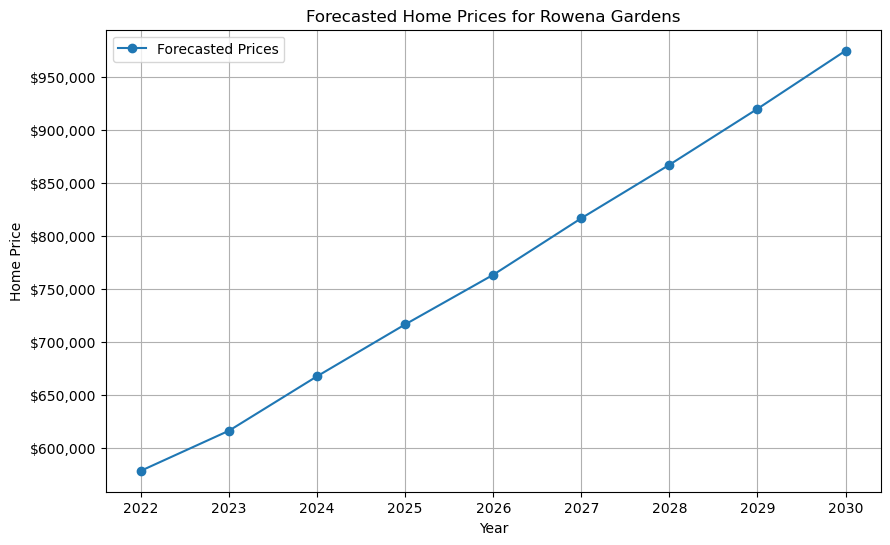

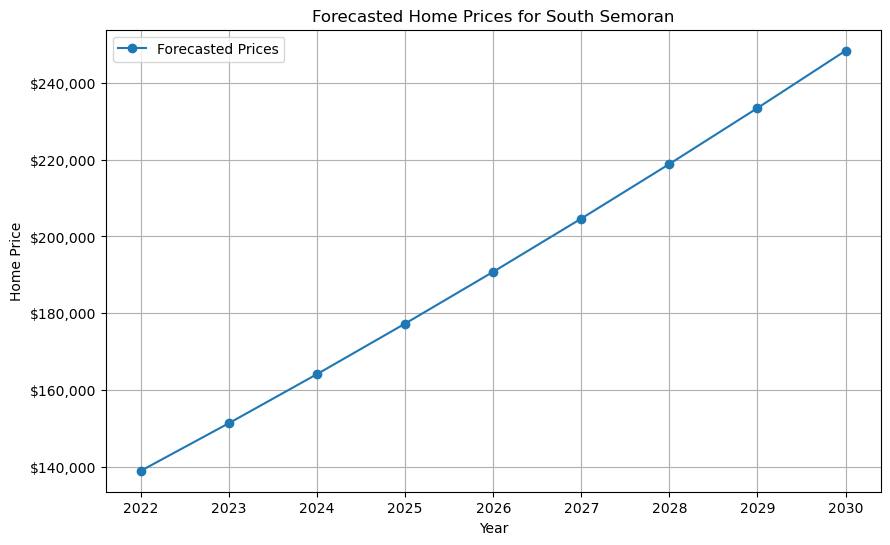

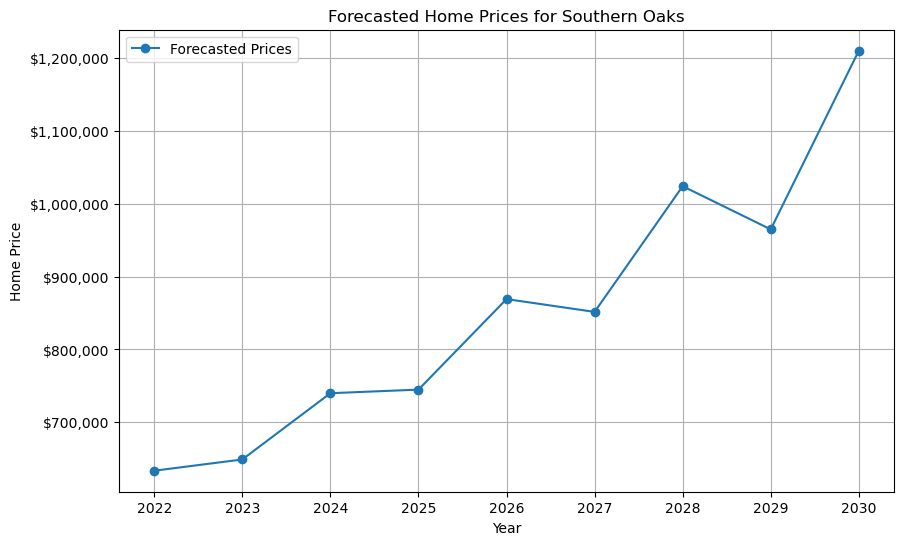

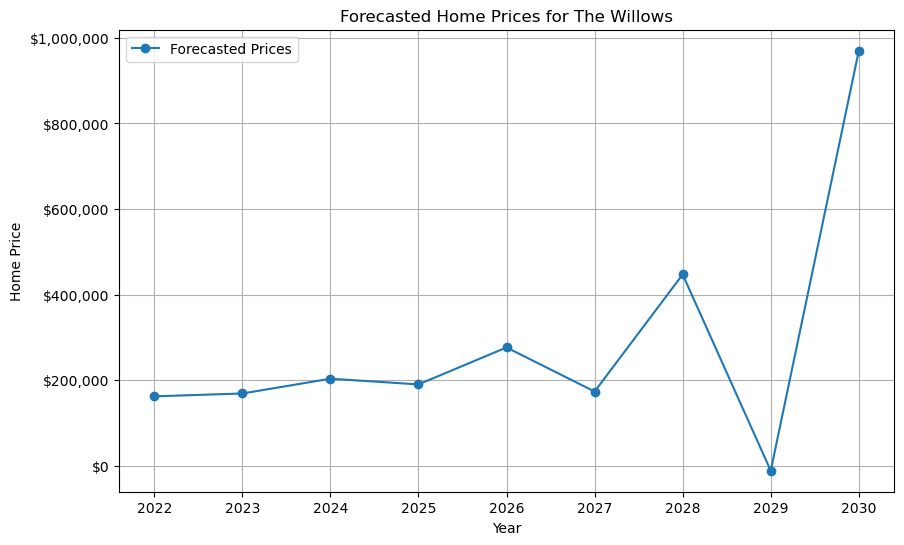

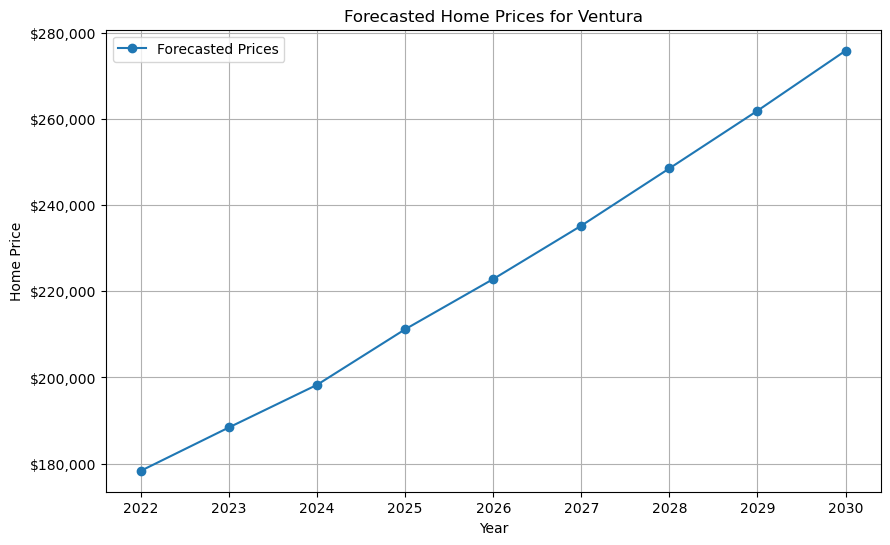

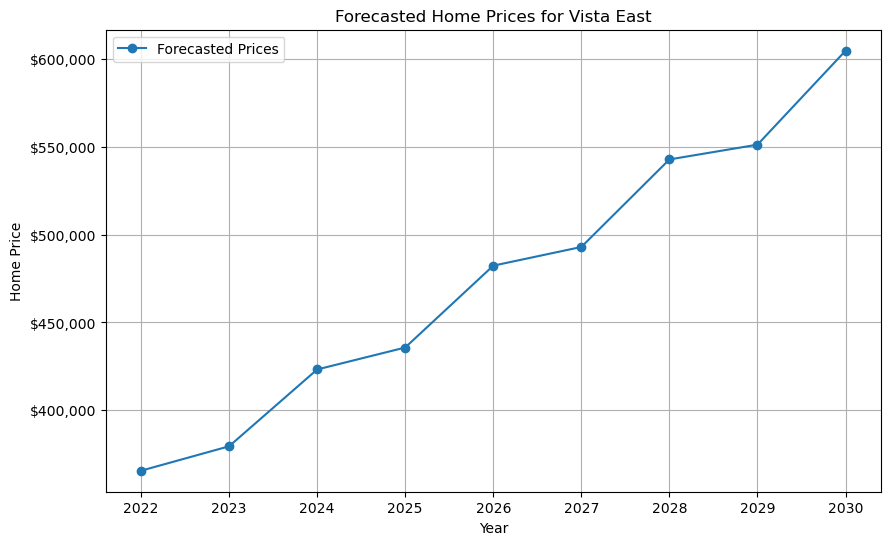

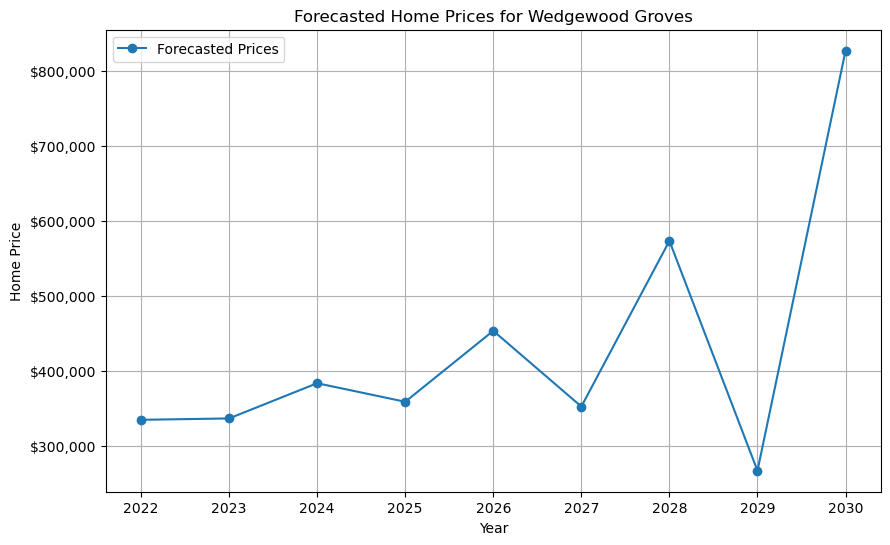

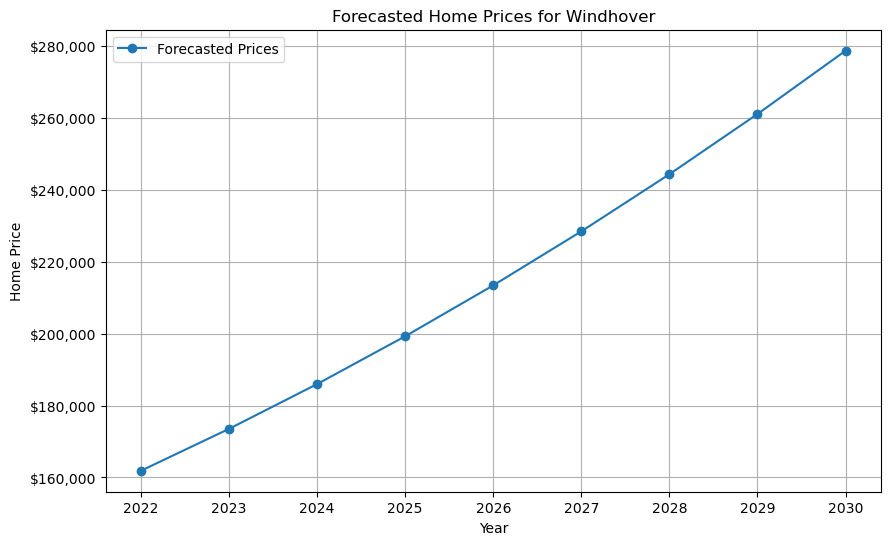

In [176]:
# Plot the forecasted home prices for each neighborhood
for neighborhood in forecast_horizon_df.index:
  plt.figure(figsize=(10, 6))
  plt.plot(forecast_horizon_df.columns, forecast_horizon_df.loc[neighborhood], marker='o', label='Forecasted Prices')
  plt.title(f'Forecasted Home Prices for {neighborhood}')
  plt.xlabel('Year')
  plt.ylabel('Home Price')
  plt.grid(True)
  plt.legend()

  # Format y-axis in dollars
  ax = plt.gca()
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

  plt.show()

## Model diagnostics

In [178]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test for each neighborhood's model
ljung_box_results = {}

for neighborhood, results in grouped_results.items():
    residuals = results.resid  # Get residuals from the model
    lb_test = {}
    for column in residuals.columns:  # Perform Ljung-Box test for each column
        max_lags = min(10, len(residuals[column]))  # Adjust lags dynamically
        lb_test[column] = acorr_ljungbox(residuals[column], lags=[1], return_df=True)
    ljung_box_results[neighborhood] = lb_test

# Create a list to store lb_pvalue data for each neighborhood and variable
lb_pvalue_data = []

# Populate the list with lb_pvalue values
for neighborhood, lb_test in ljung_box_results.items():
  lb_pvalue_data.append({
    "neighborhood": neighborhood,
    "zillow": lb_test["zillow"]["lb_pvalue"].iloc[0],
    "income": lb_test["income"]["lb_pvalue"].iloc[0],
    "unemployment": lb_test["unemployment"]["lb_pvalue"].iloc[0]
  })

# Convert the list to a DataFrame
lb_pvalue_df = pd.DataFrame(lb_pvalue_data)

# Print the resulting DataFrame
print(lb_pvalue_df.sort_values(by="zillow", ascending=False).head(10))

        neighborhood  zillow  income  unemployment
16   Lake Nona South    1.00    1.00          1.00
29           Ventura    0.97    0.68          0.52
22  Richmond Estates    0.95    0.91          0.88
19       Orwin Manor    0.93    0.81          0.57
10    Engelwood Park    0.90    0.53          0.66
8             Conway    0.88    0.77          0.48
28       The Willows    0.88    0.52          0.98
17      Lake Terrace    0.88    0.42          0.68
31  Wedgewood Groves    0.82    0.04          0.91
3          Bryn Mawr    0.79    0.06          0.97


c:\Users\brad\miniconda3\envs\ds\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


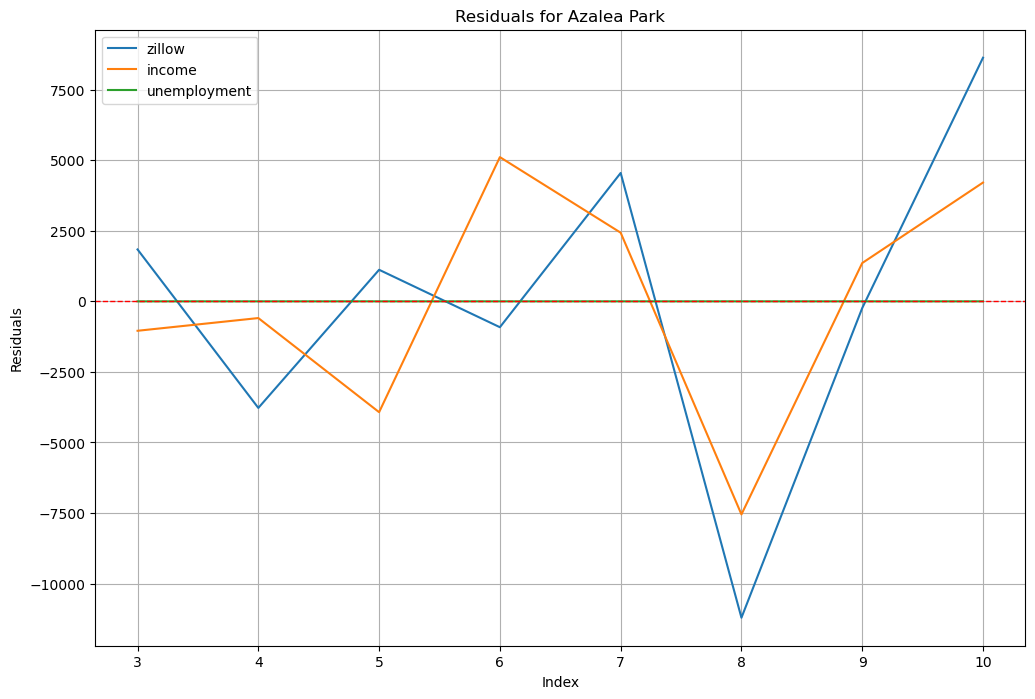

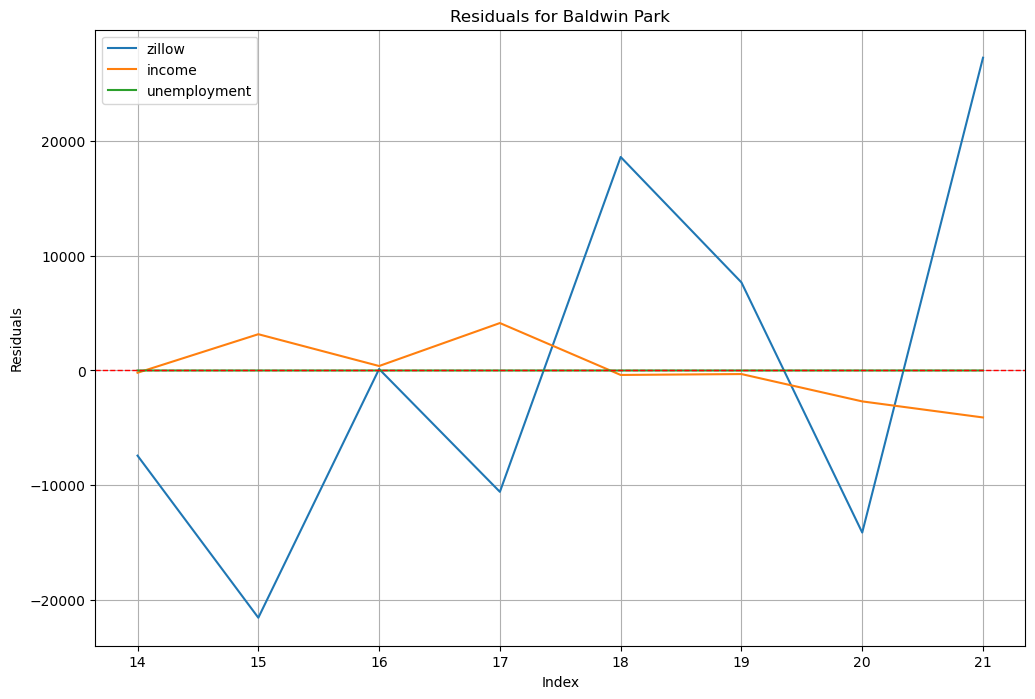

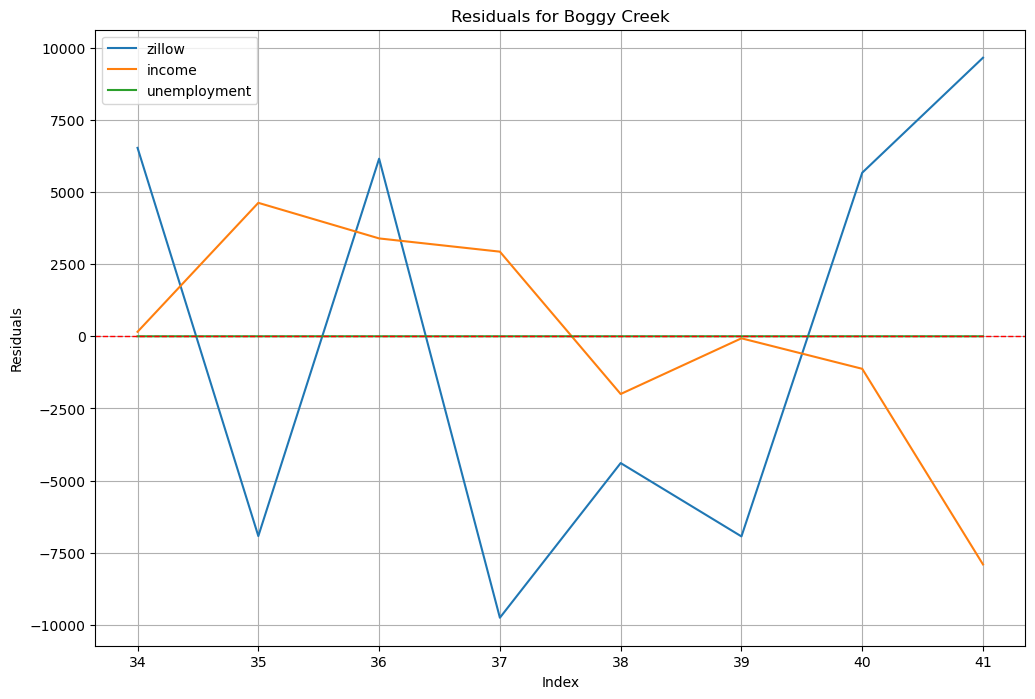

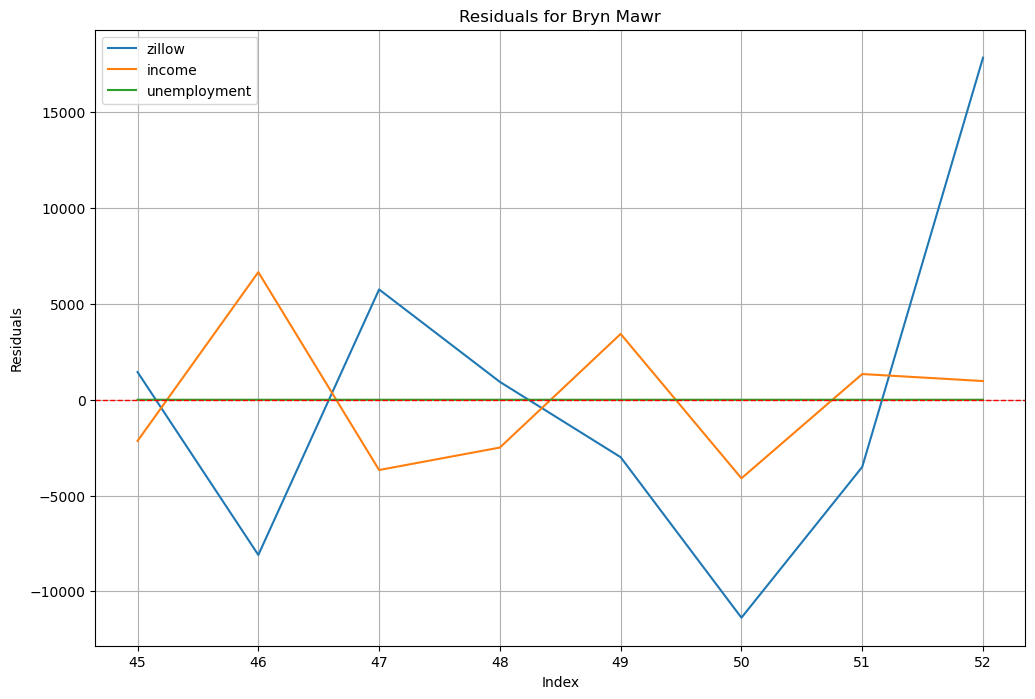

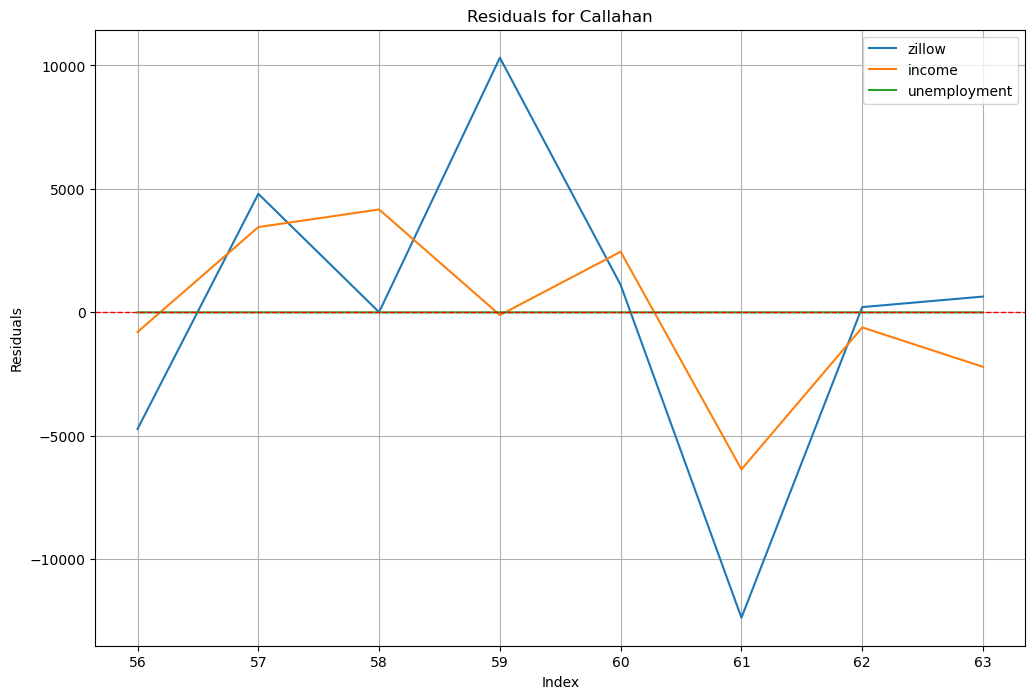

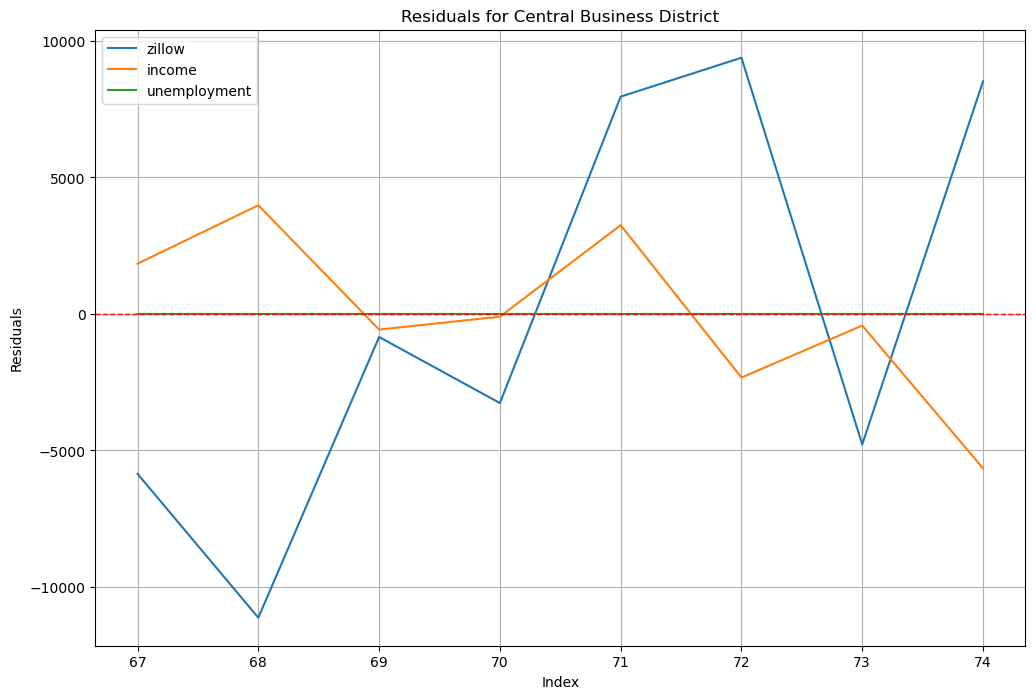

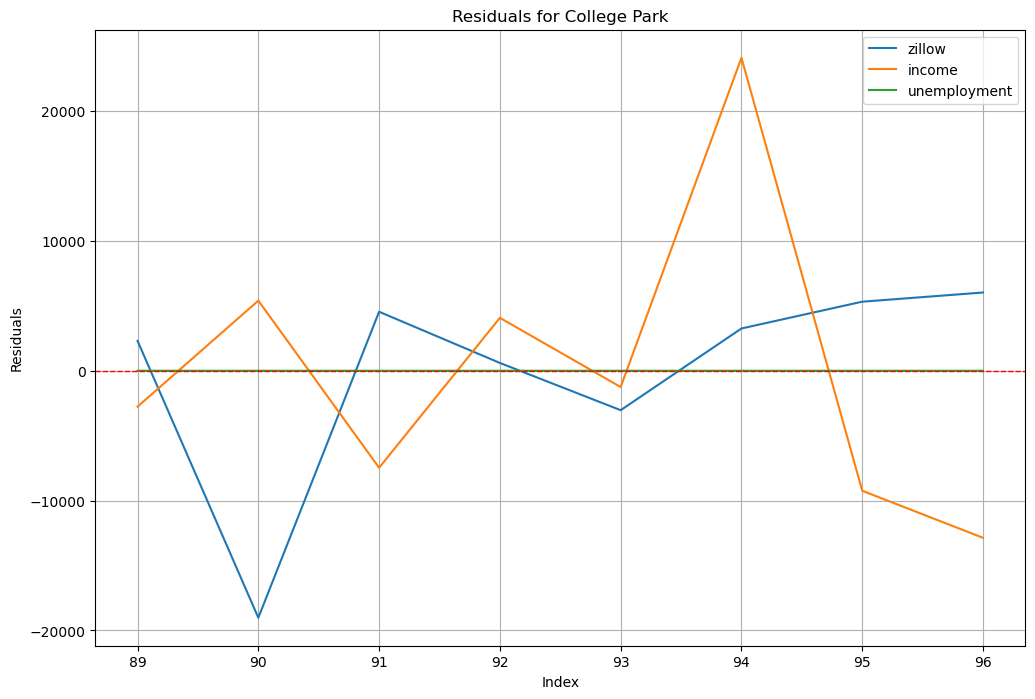

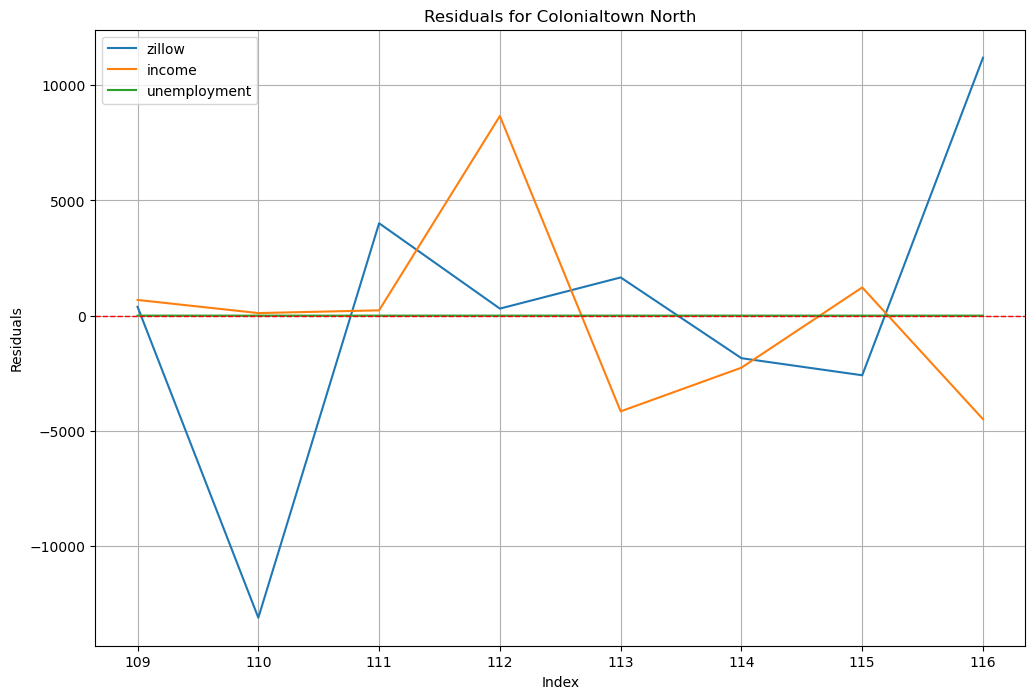

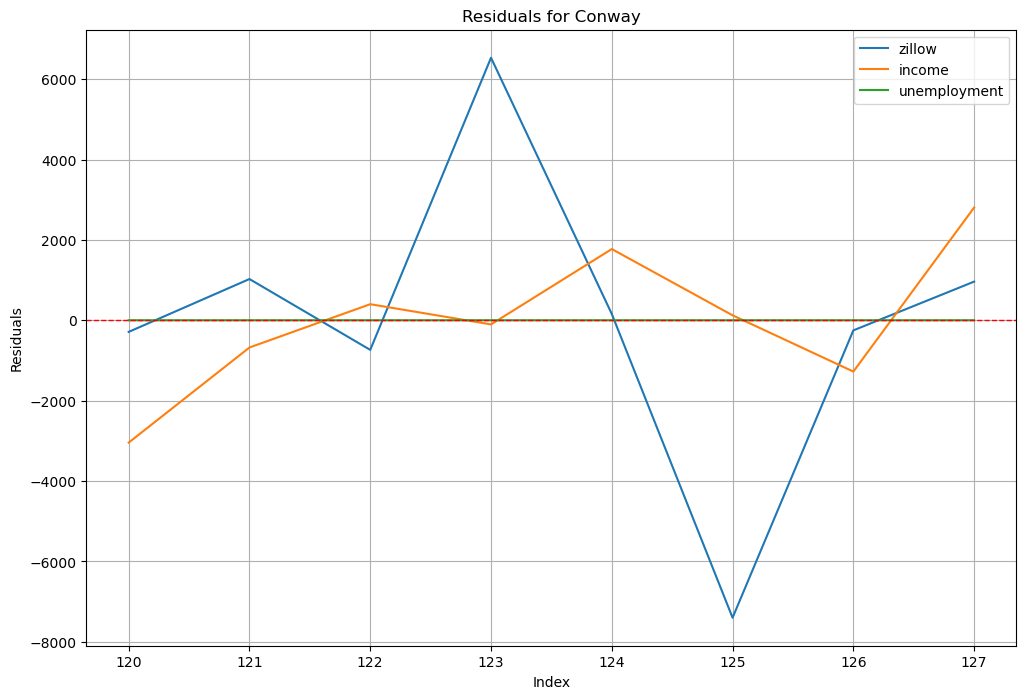

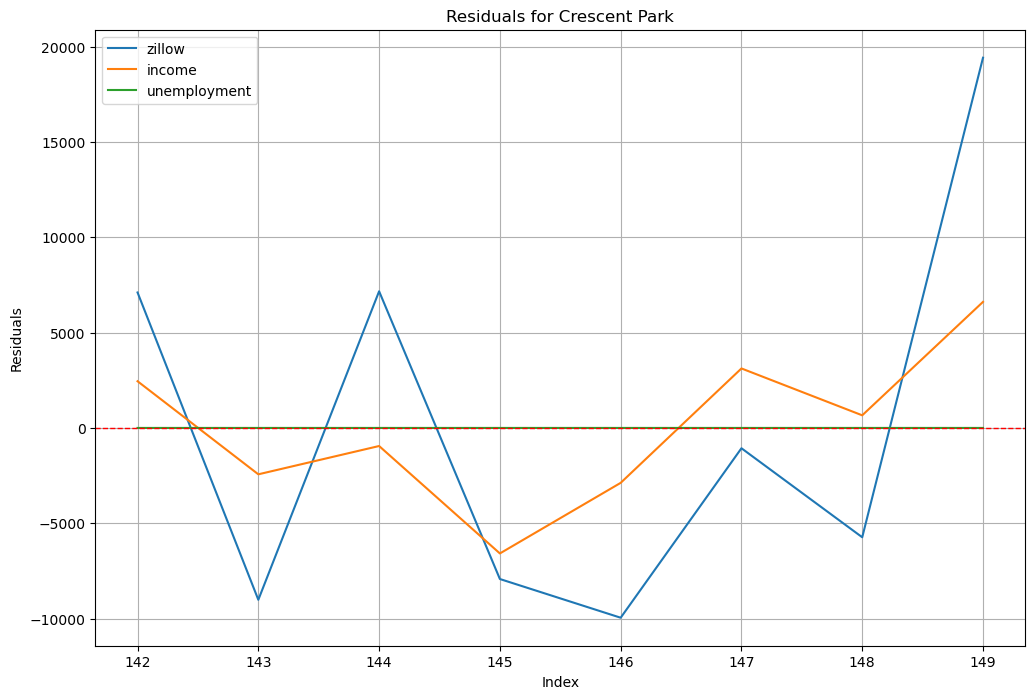

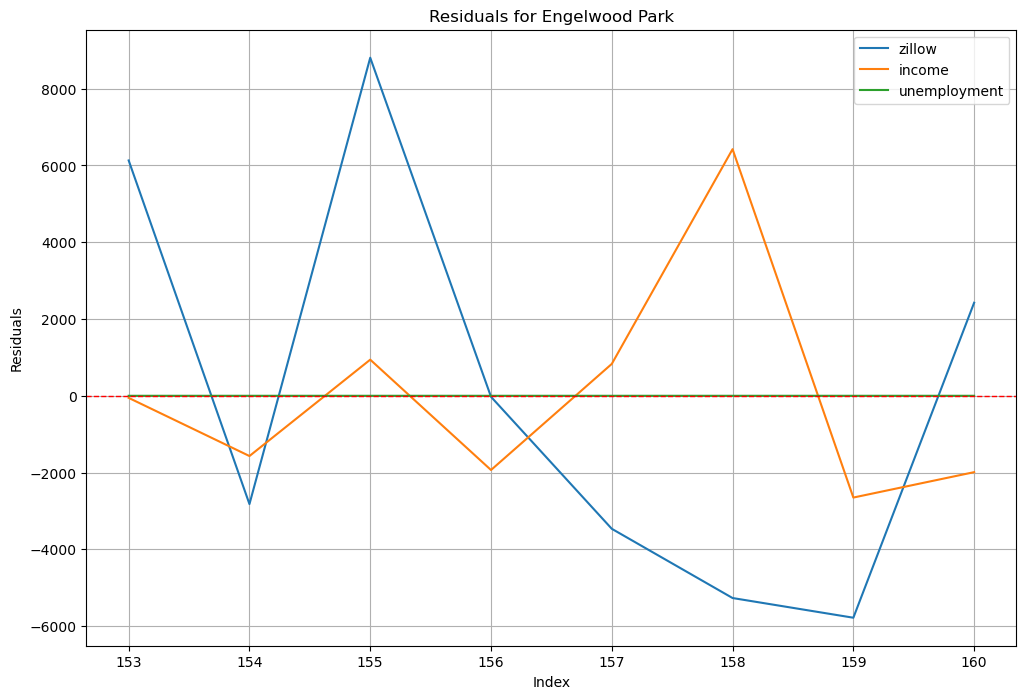

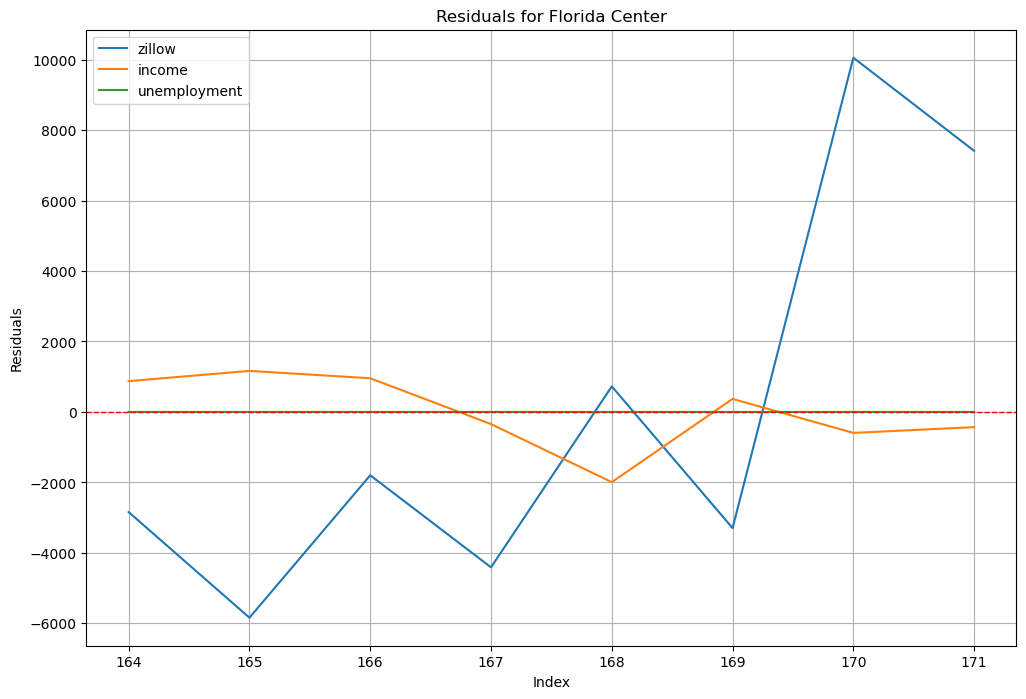

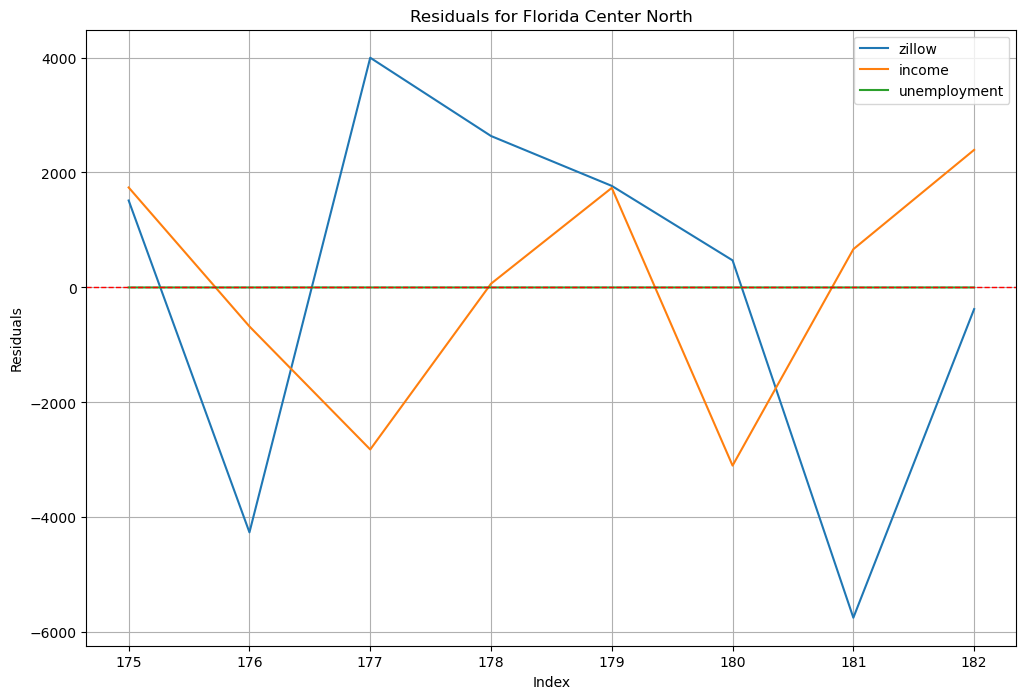

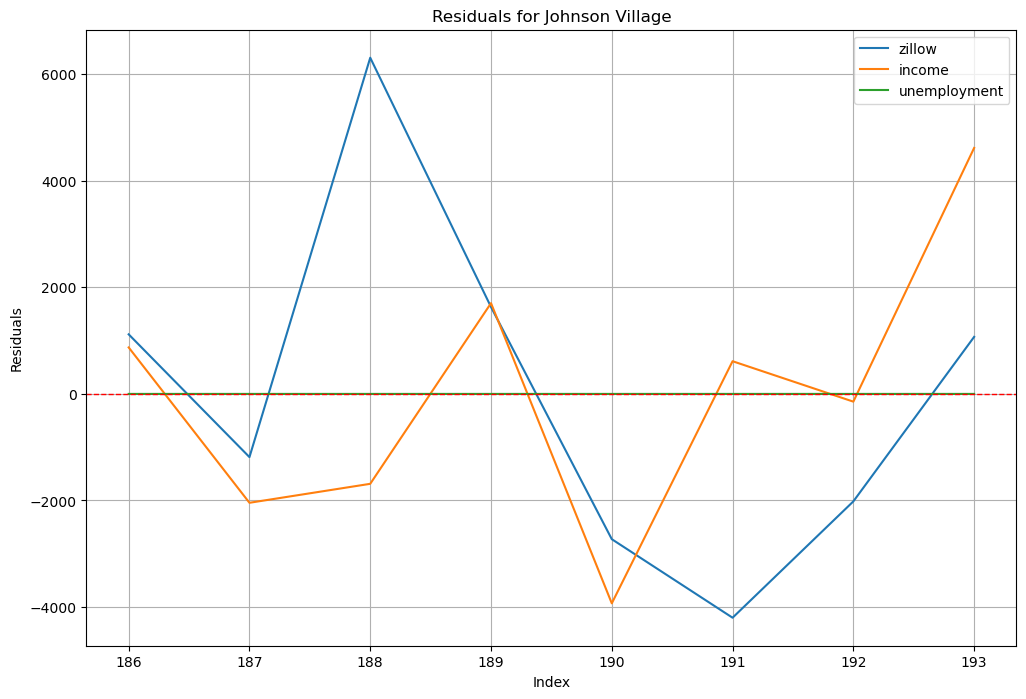

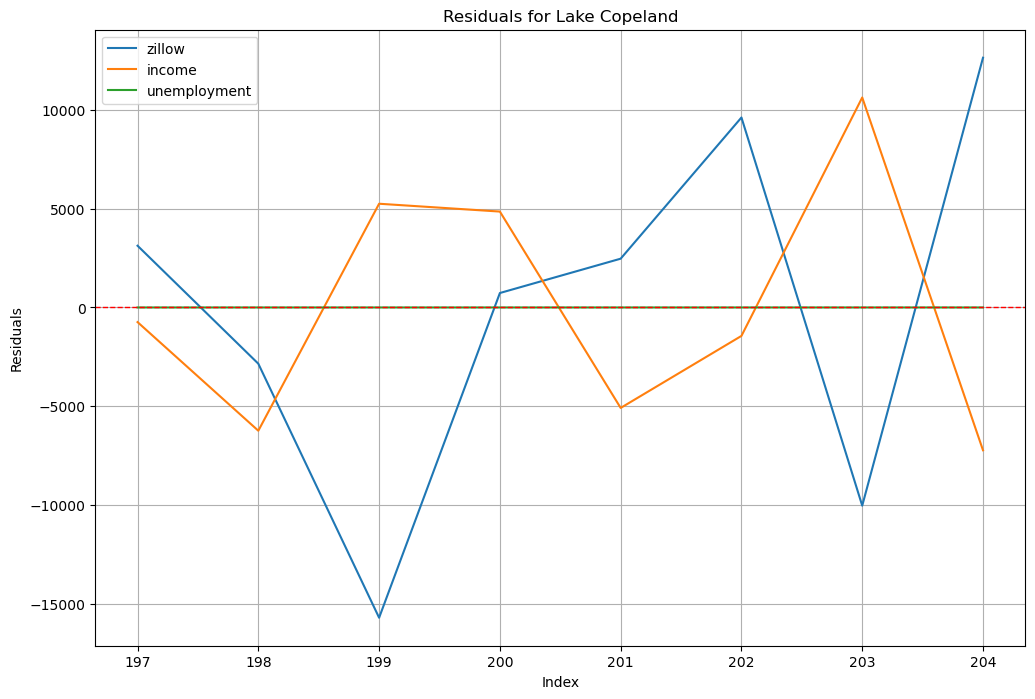

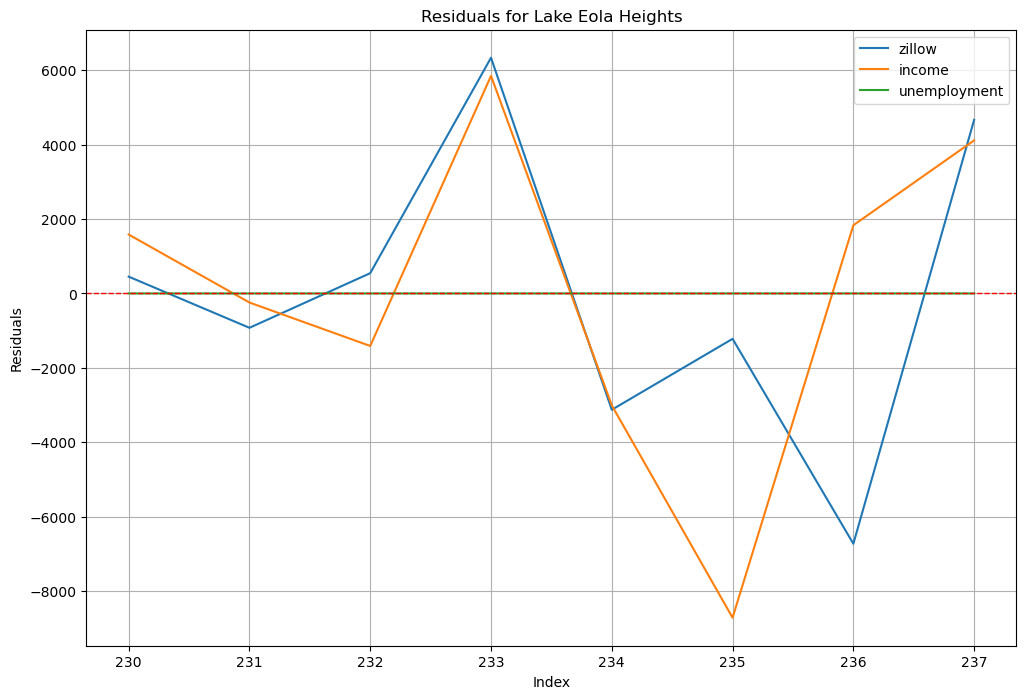

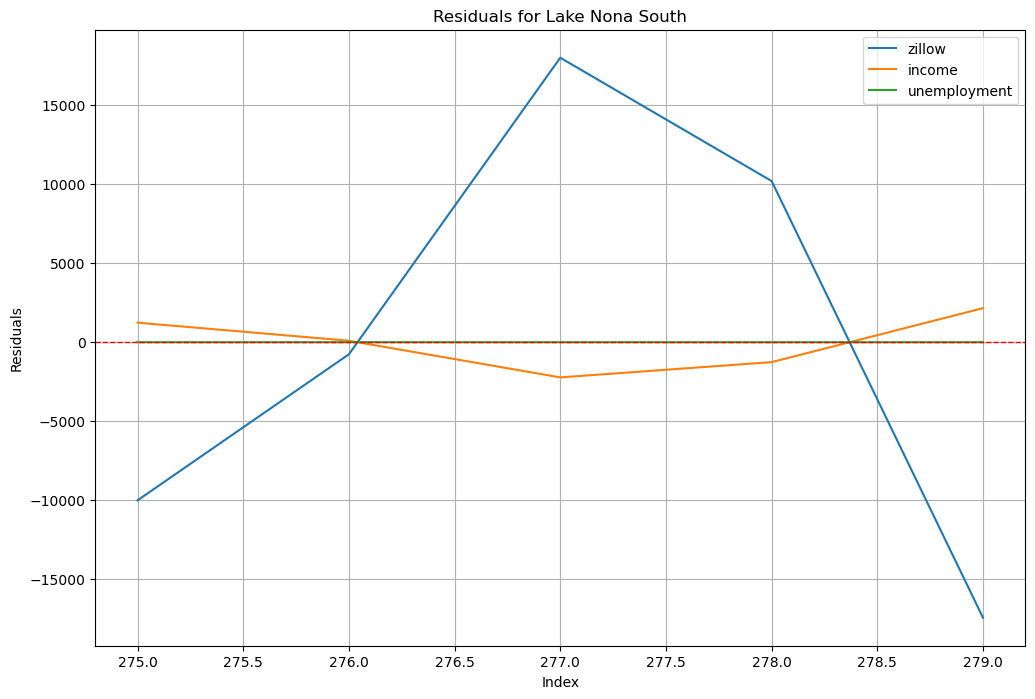

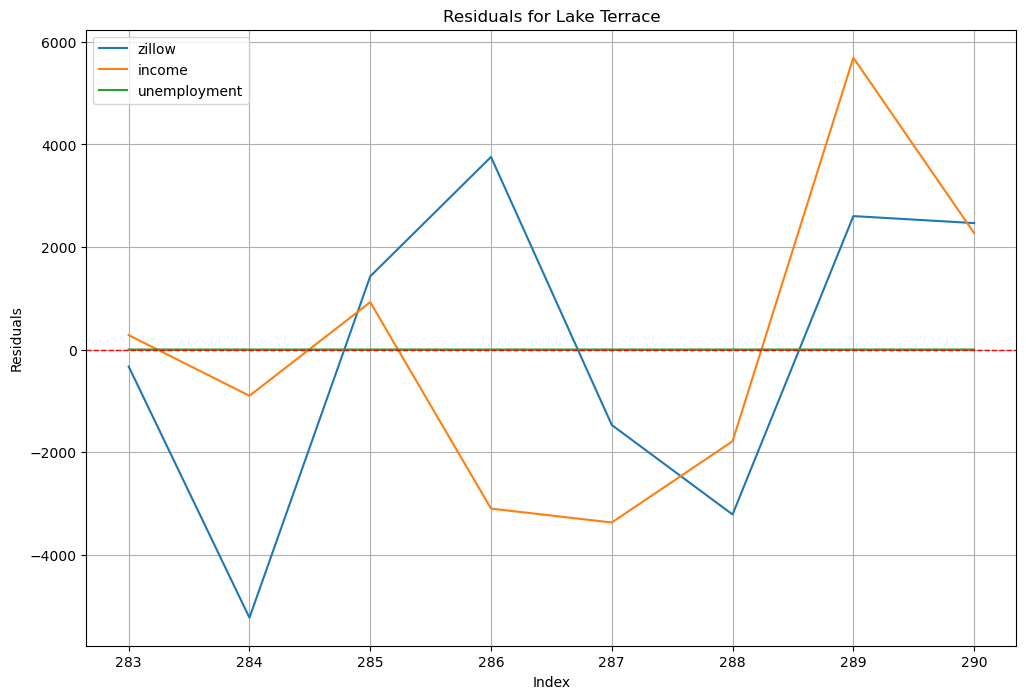

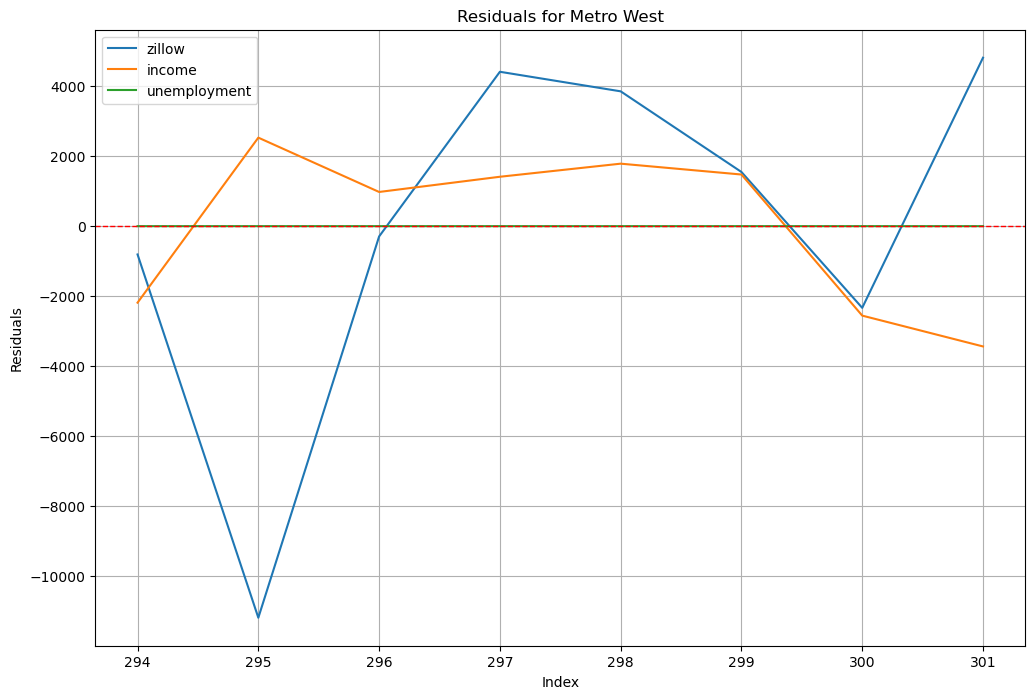

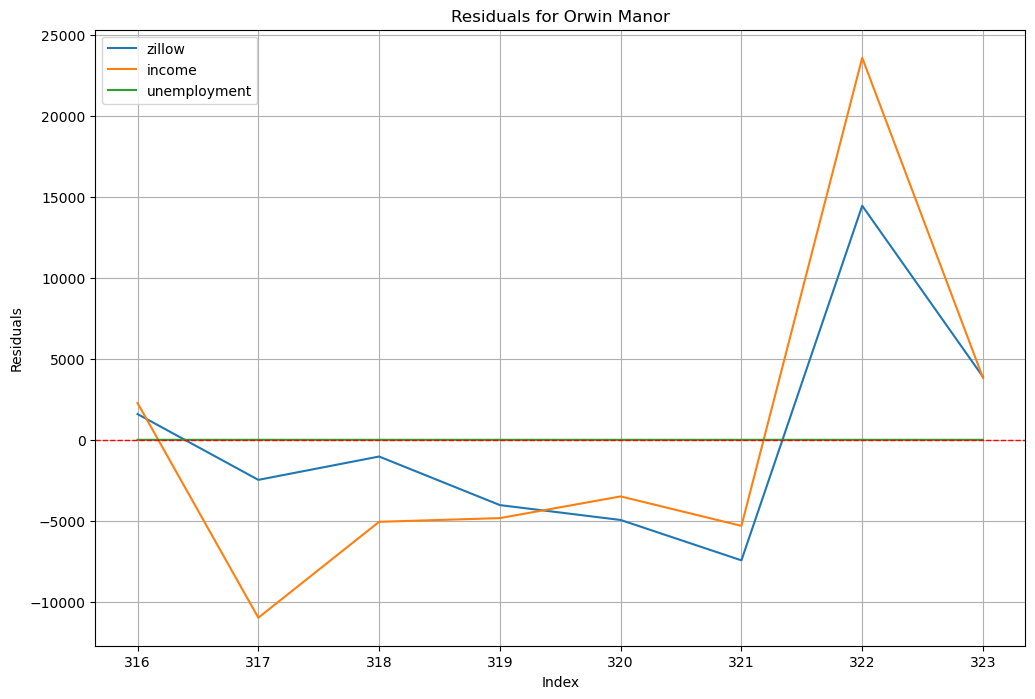

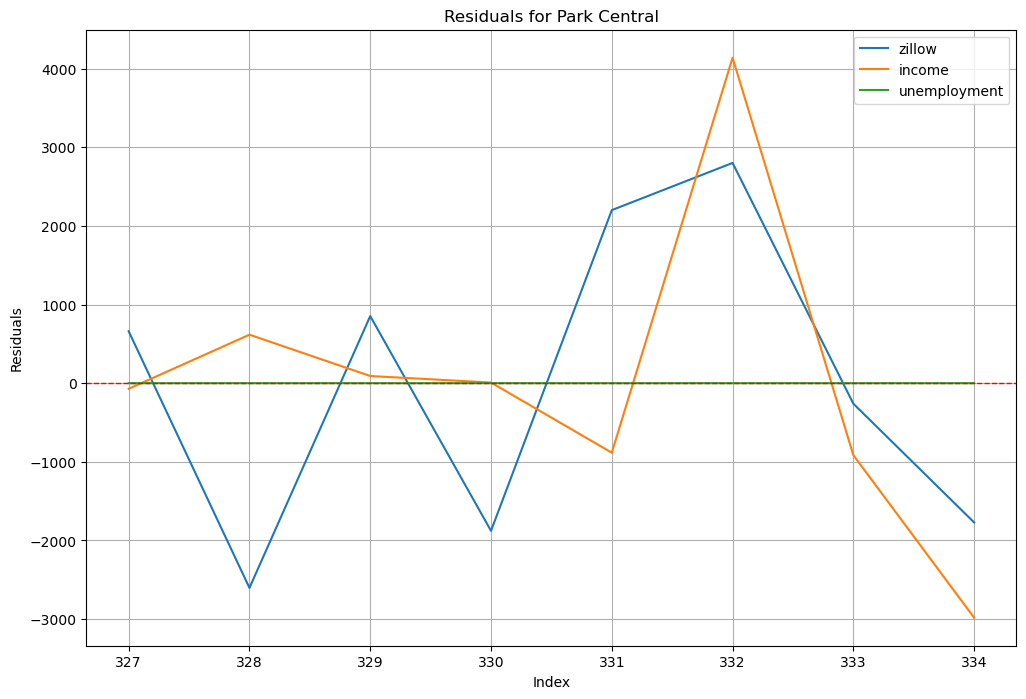

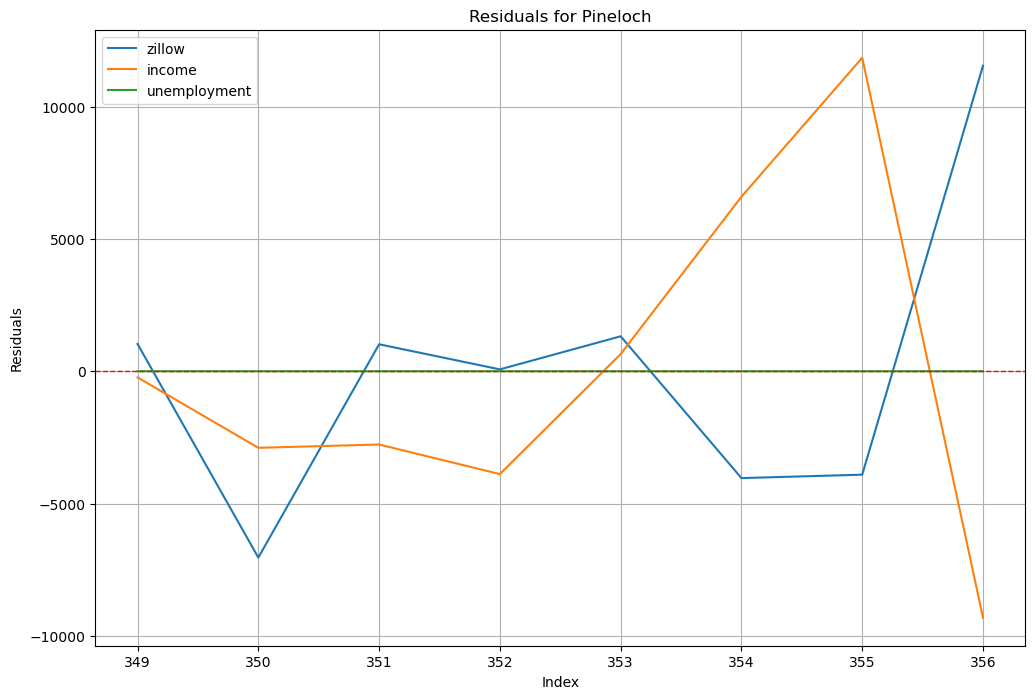

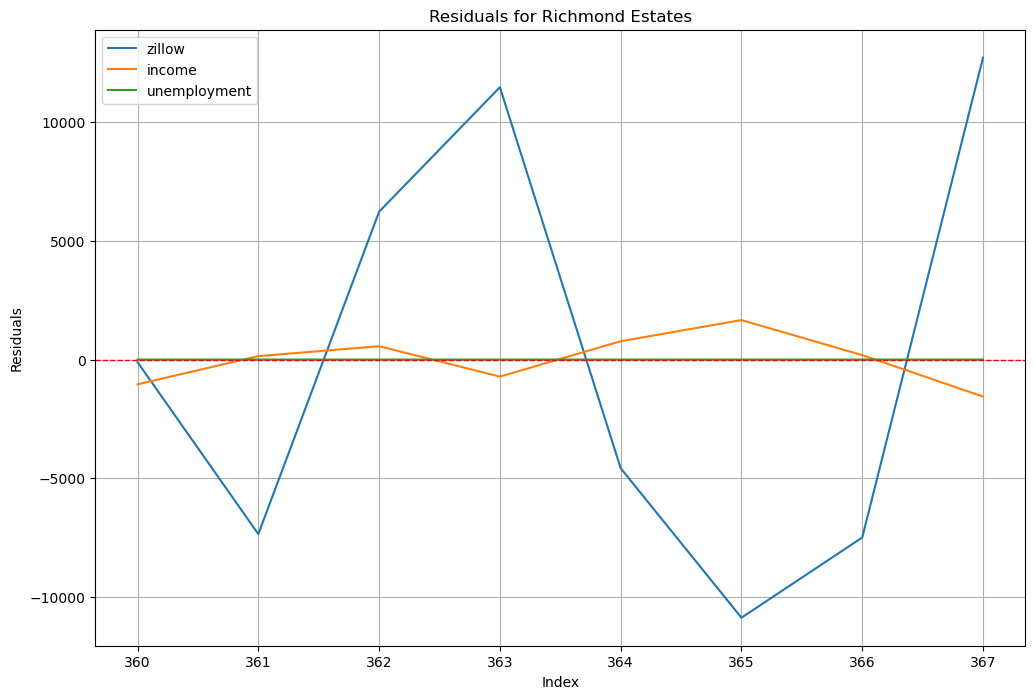

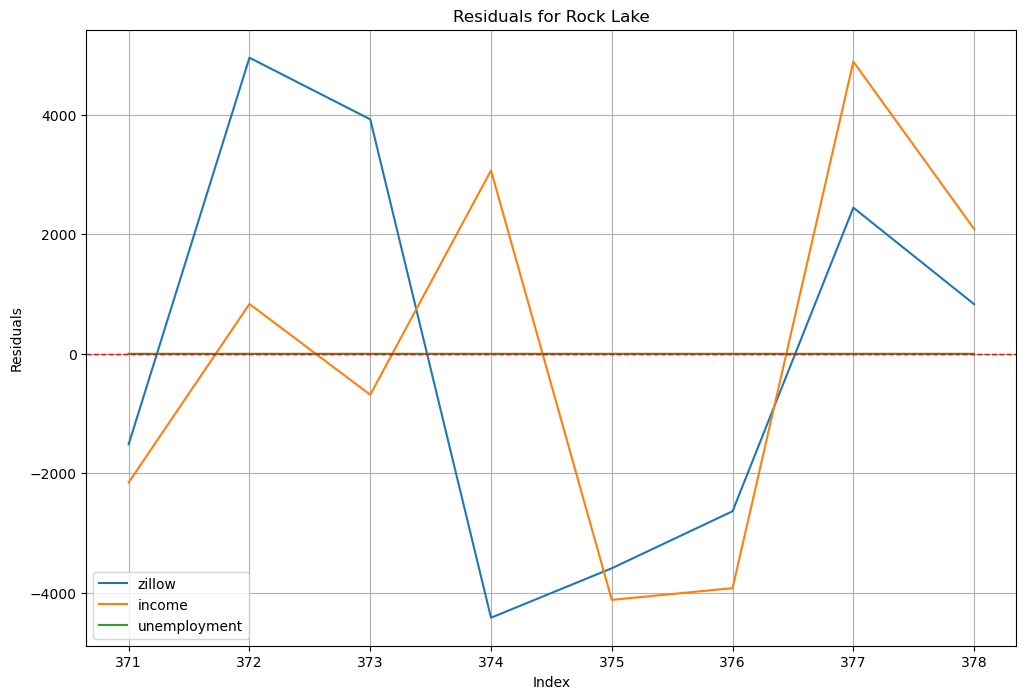

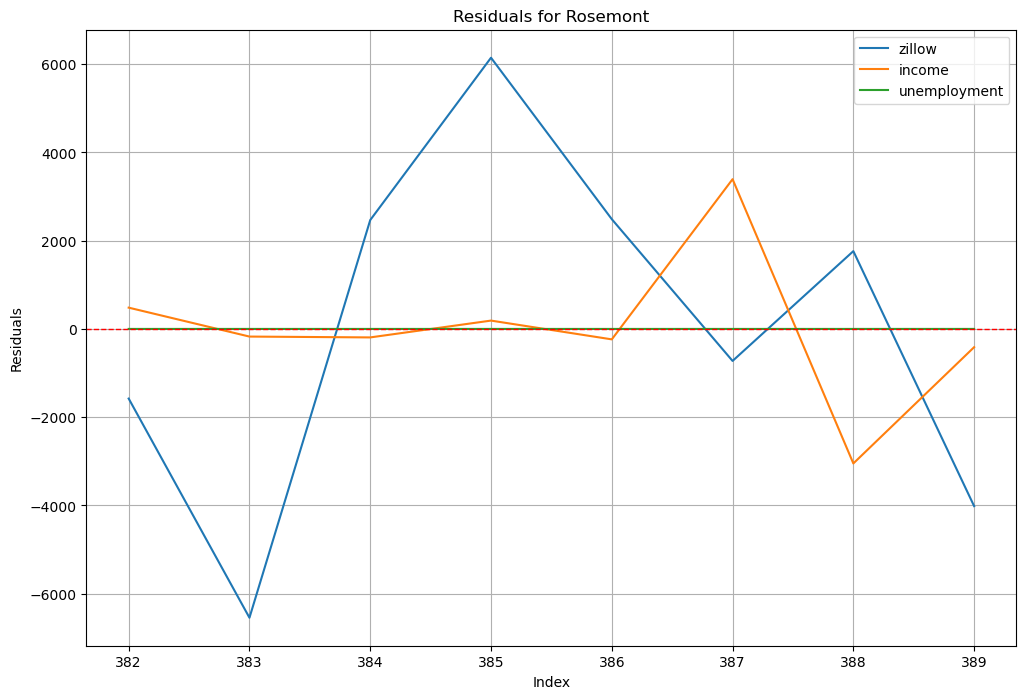

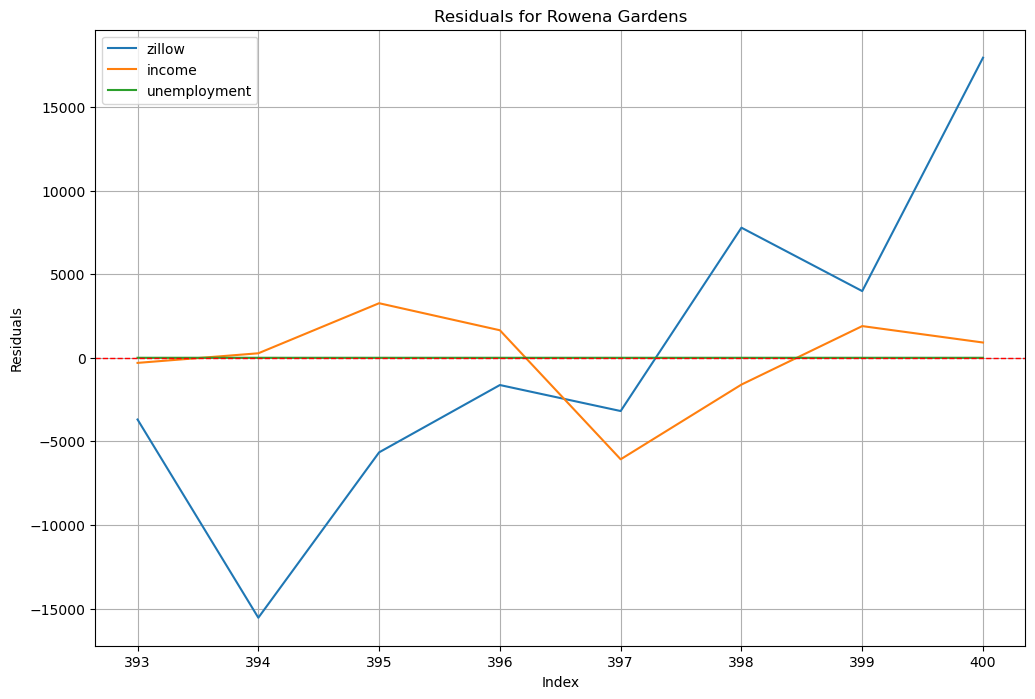

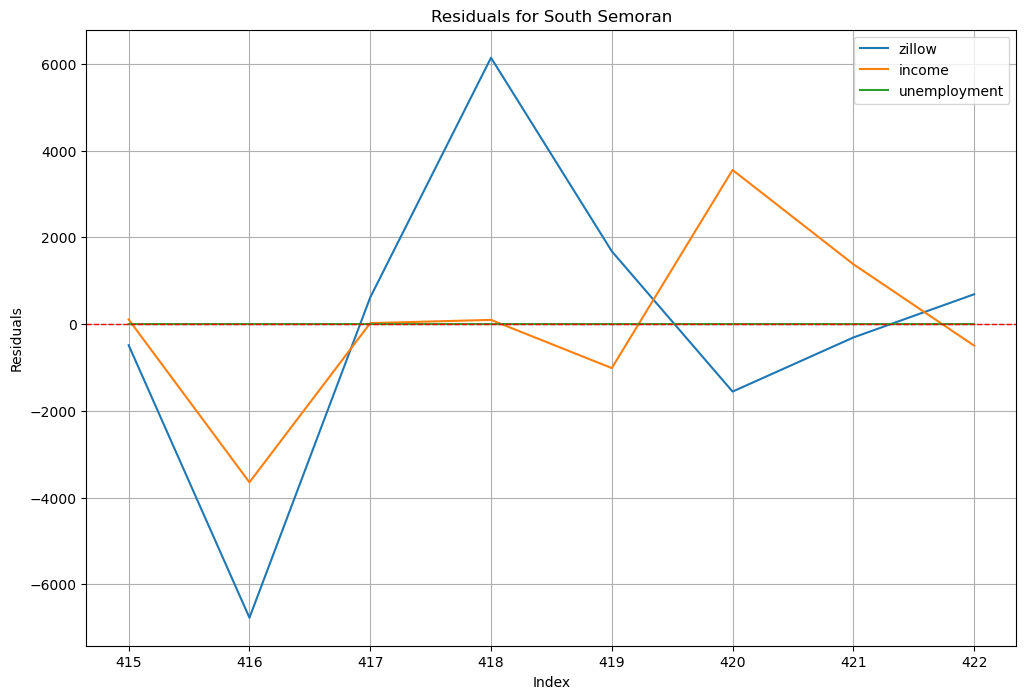

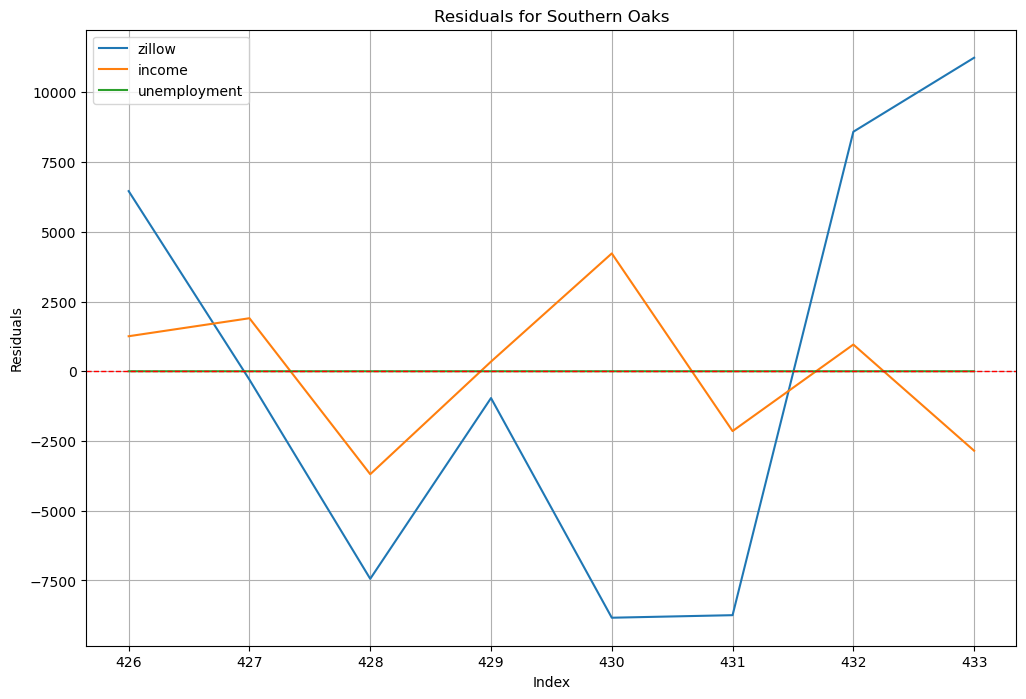

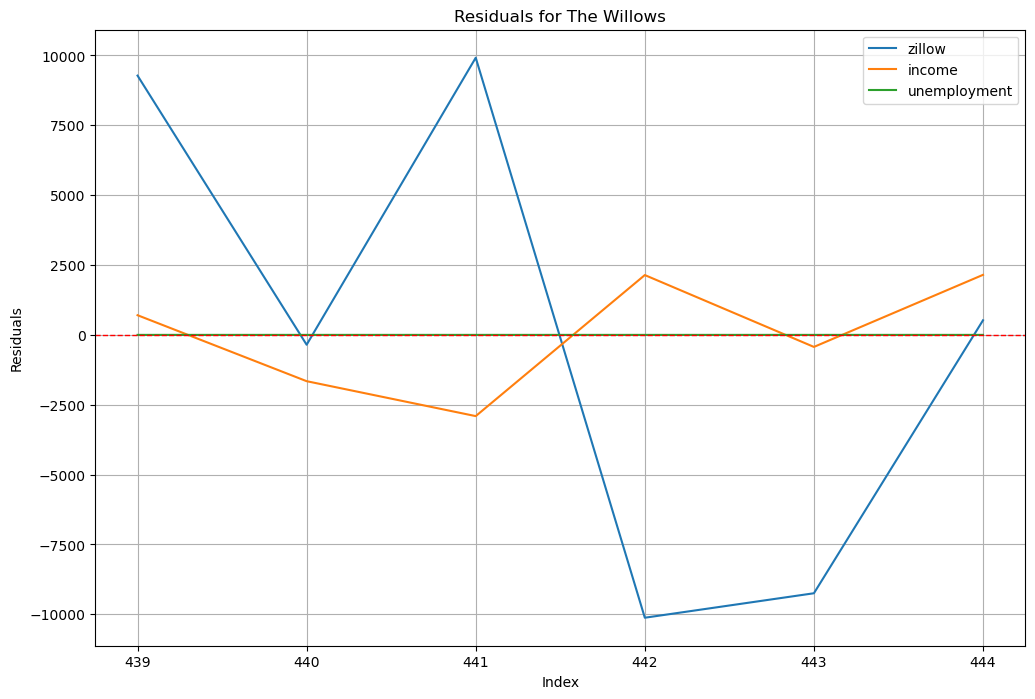

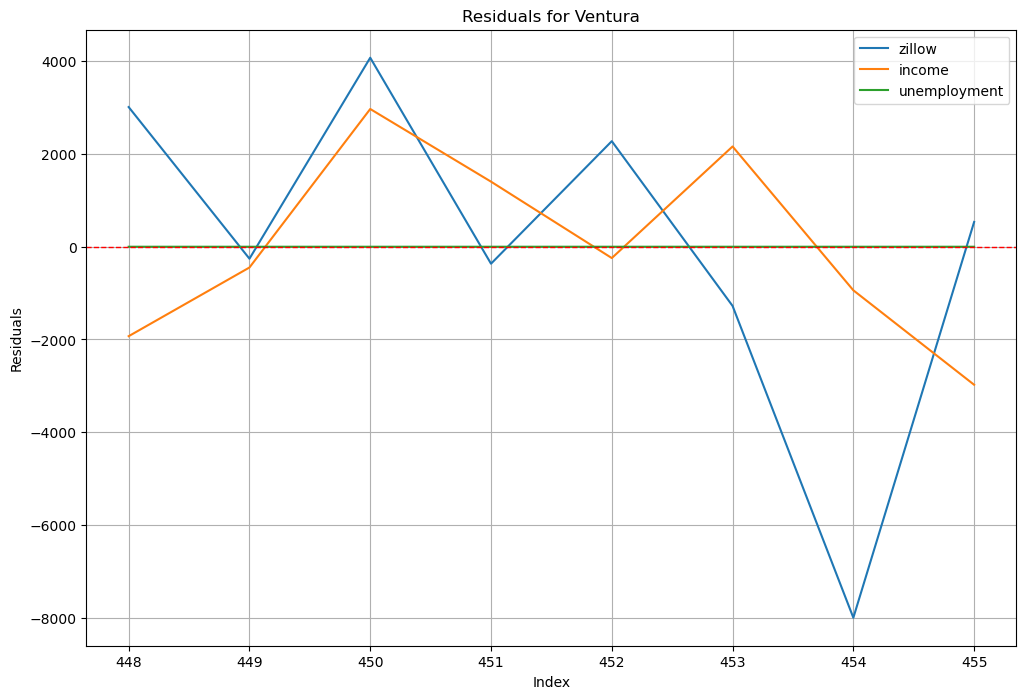

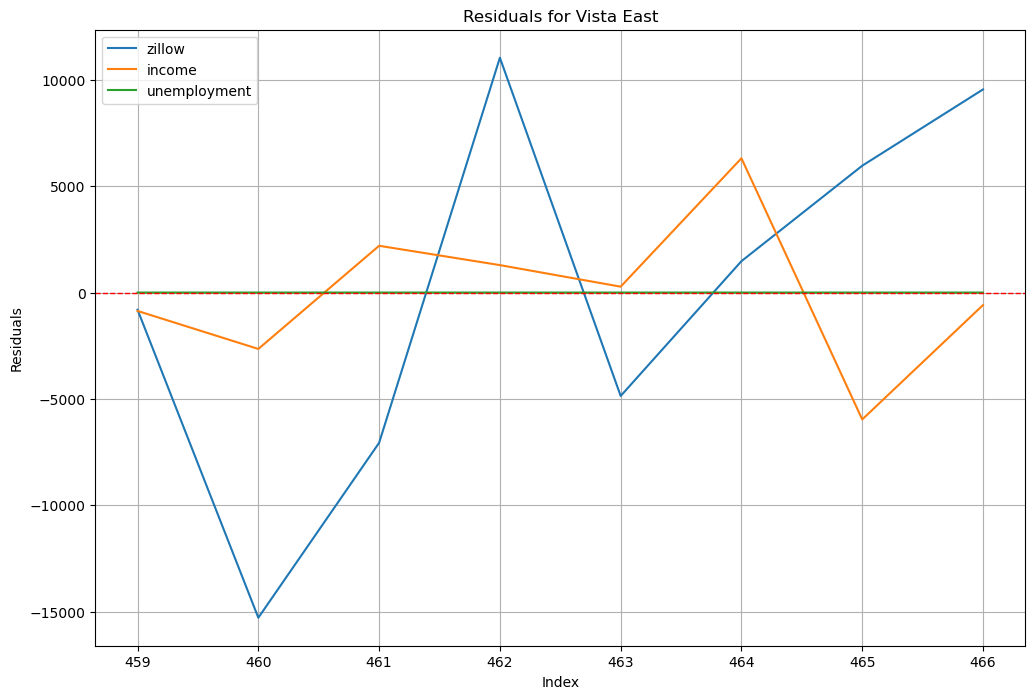

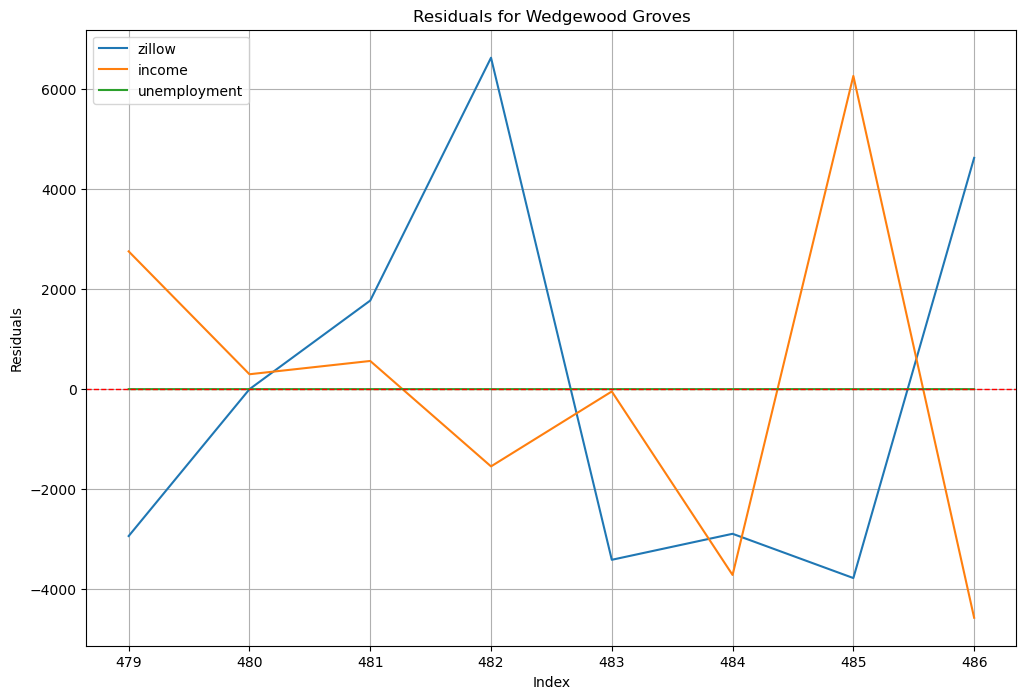

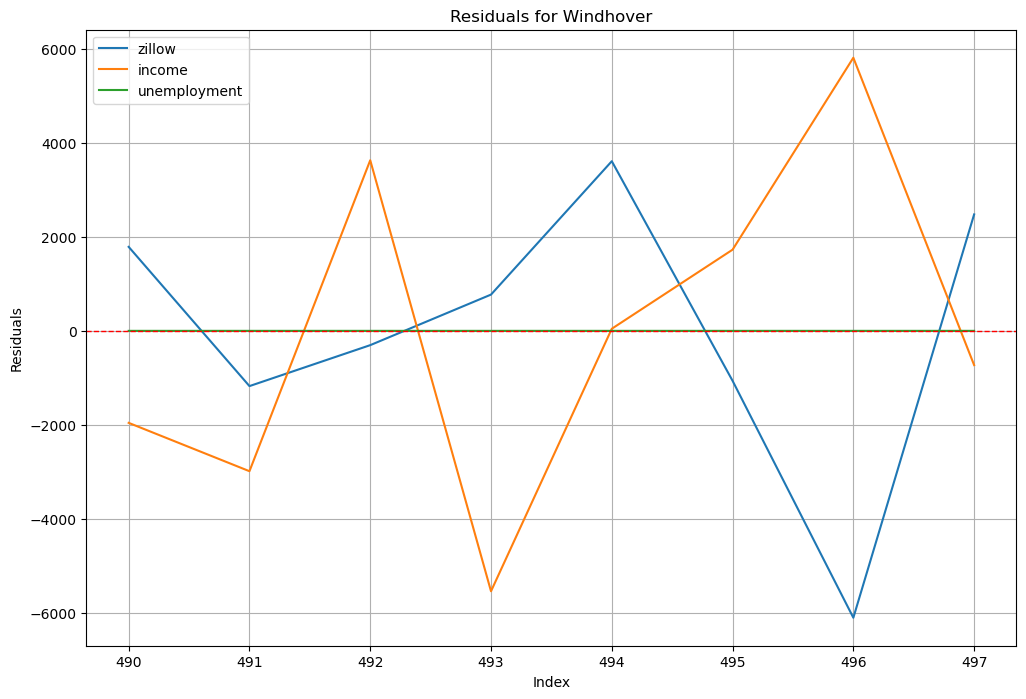

In [179]:
import matplotlib.pyplot as plt

# Iterate through each neighborhood and its corresponding model results
for neighborhood, results in grouped_results.items():
  residuals = results.resid.drop(columns=['year'], errors='ignore')  # Drop 'year' column if it exists

  # Plot all residuals on the same plot
  plt.figure(figsize=(12, 8))
  for column in residuals.columns:
    plt.plot(residuals.index, residuals[column], label=f'{column}')
  plt.axhline(0, color='red', linestyle='--', linewidth=1)
  plt.title(f'Residuals for {neighborhood}')
  plt.xlabel('Index')
  plt.ylabel('Residuals')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Your existing code here
# Container to store evaluation metrics
evaluation_metrics = {}

# Loop through each neighborhood in grouped_results
for neighborhood, results in grouped_results.items():
  # Get the original data for the neighborhood
  neighborhood_data = var_df[var_df["neighborhood"] == neighborhood].sort_values("year")
  
  # Calculate the number of rows to exclude (last 10%)
  exclude_count = max(1, int(len(neighborhood_data) * 0.1))
  
  # Leave out the last 10% of data
  train_data = neighborhood_data.iloc[:-exclude_count]
  test_data = neighborhood_data.iloc[-exclude_count:]
  
  # Prepare the training data for the VAR model
  train_df = train_data.drop(columns=["neighborhood", "distance", "duration"]).diff().diff().dropna()
  
  # Check if enough data points are available after differencing
  if len(train_df) <= 1:  # At least 2 data points needed for lag 1
    print(f"Skipping {neighborhood} due to insufficient data after differencing.")
    continue
  
  # Fit the VAR model on the training data
  model = VAR(train_df)
  results = model.fit()
  
  # Forecast the excluded observations
  forecast = results.forecast(results.endog[-results.k_ar:], steps=len(test_data))
  forecast_df = pd.DataFrame(forecast, columns=results.names)
  
  # Calculate RMSE, MAE, and MAPE for the forecasted values
  y_true = test_data[results.names].values.flatten()
  y_pred = forecast_df.values.flatten()
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage
  
  # Store the metrics
  evaluation_metrics[neighborhood] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# Convert the evaluation metrics dictionary to a DataFrame for sorting
evaluation_metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Sort the DataFrame by MAE and display the top 10 neighborhoods
print(evaluation_metrics_df.sort_values("MAE").head(10))

C:\Users\brad\AppData\Local\Temp\ipykernel_20108\2459731084.py:43: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage


                         RMSE      MAE   MAPE
Park Central         68561.00 40035.10 100.99
South Semoran        66221.35 41607.72 141.52
The Willows          73194.41 46093.57  98.18
Conway               73472.55 47538.55  98.21
Florida Center North 75163.84 47558.09  90.80
Callahan             78745.34 49057.92 112.46
Ventura              82156.12 49386.09 101.31
Johnson Village      81632.89 50819.11 102.32
Windhover            83811.47 51579.84 130.95
Rosemont             86313.65 52037.80 104.56


# Prophet Model

In [84]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [85]:
with open('../sql-scripts/prophet.txt', 'r') as sql_file:
  sql_script = sql_file.read()

conn = sqlite3.connect('orlando.db')
prophet_df = pd.read_sql_query(sql_script, conn)
conn.close()

## Fit the model and diagnostics

In [181]:
# Define an evaluation function for the test set forecast
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # expressed as percentage
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Ensure your date column is in datetime format and rename columns for Prophet
prophet_df["ds"] = pd.to_datetime(prophet_df["period"])
prophet_df = prophet_df.rename(columns={'value': 'y'})

# Define a cutoff date for training/test split (adjust as needed)
cutoff_date = "2023-01-01"

# Container to hold results for each neighborhood
results = []

# Loop over each neighborhood (using "neighborhood")
for neighborhood, group_df in prophet_df.groupby("neighborhood"):
    # Sort by date (the "ds" column)
    group_df = group_df.sort_values("ds")

    # Split the data: training before cutoff, test starting from cutoff
    train_df = group_df[group_df["ds"] < cutoff_date].copy()
    test_df  = group_df[group_df["ds"] >= cutoff_date].copy()

    # Skip neighborhoods with insufficient training or testing data
    if train_df["y"].notna().sum() < 2 or test_df["y"].notna().sum() < 1:
        print(f"Skipping {neighborhood} due to insufficient data: "
              f"train count = {train_df['y'].notna().sum()}, "
              f"test count = {test_df['y'].notna().sum()}")
        continue

    # Fit Prophet on the training data
    m = Prophet()
    try:
        m.fit(train_df)
    except Exception as e:
        print(f"Error fitting Prophet for {neighborhood}: {e}")
        continue

    # --- Evaluate on Test Data ---
    # Create a future dataframe covering the test period (same number of periods as in test)
    future_test = m.make_future_dataframe(periods=len(test_df), freq="ME")
    forecast_test = m.predict(future_test)

    # Select only the forecasted values in the test period (using the cutoff date)
    forecast_test = forecast_test[forecast_test["ds"] >= cutoff_date]
    y_true = test_df["y"].values
    y_pred = forecast_test["yhat"].values
    metrics_dict = evaluate_forecast(y_true, y_pred)

    # --- Forecast 10 Years into the Future ---
    future_8yr = m.make_future_dataframe(periods=120, freq="ME")
    forecast_8yr = m.predict(future_8yr)

    # Collect results for the current region
    results.append({
        "neighborhood": neighborhood,
        "metrics": metrics_dict,
        "forecast_test": forecast_test,
        "forecast_8yr": forecast_8yr
    })

# Convert the results list to a DataFrame of metrics (for summary, if desired)
metrics_df = pd.DataFrame([{"neighborhood": r["neighborhood"], **r["metrics"]} for r in results])

print(metrics_df.sort_values("MAE").head(10))

21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1]

Skipping Countryside due to insufficient data: train count = 0, test count = 16


21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1]

Skipping New Malibu due to insufficient data: train count = 0, test count = 16


21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1]

          neighborhood     MAE     RMSE  MAPE
105      West Colonial 4841.73  5839.36  2.07
63         Mercy Drive 5060.80  6601.16  2.34
79           Rock Lake 6920.12  8051.87  2.31
42           Lake Como 7182.38 10657.64  1.54
26   East Central Park 7269.65  8999.51  2.05
3          Azalea Park 7317.87  9525.28  2.31
18             Coytown 7511.90  9630.46  1.79
29     Fairview Shores 7625.15  8756.55  2.32
77    Richmond Heights 7713.04 10677.52  3.19
85         Signal Hill 7796.34  9413.75  3.02


## Forecast model

In [182]:
# Create a DataFrame to store yearly forecasts for each neighborhood
yearly_forecast_df = pd.DataFrame()

# Loop through each neighborhood's forecast in the results
for result in results:
    neighborhood = result["neighborhood"]
    forecast_8yr = result["forecast_8yr"]

    # Extract the year from the 'ds' column and calculate the yearly average
    forecast_8yr["year"] = forecast_8yr["ds"].dt.year
    yearly_avg = forecast_8yr.groupby("year")["yhat"].mean()

    # If the DataFrame is empty, initialize it with the years as the index
    if yearly_forecast_df.empty:
        yearly_forecast_df = pd.DataFrame(index=yearly_avg.index)

    # Add the yearly averages as a column in the DataFrame
    yearly_forecast_df[neighborhood] = yearly_avg

# Transpose the DataFrame for better readability (neighborhoods as rows, years as columns)
yearly_forecast_df = yearly_forecast_df.T

# Filter the DataFrame to include only columns from 2022 to 2030
yearly_forecast_df = yearly_forecast_df.loc[:, 2022:2030]

# Display the filtered DataFrame
print(yearly_forecast_df)

year                   2022      2023      2024      2025      2026      2027  \
Airport North     245563.89 268773.84 291919.26 315220.63 338430.62 361640.56   
Alafaya           396430.79 427371.70 458059.80 489323.35 520264.93 551205.85   
Audubon Park      414180.39 446574.65 479016.90 511427.75 543821.90 576216.16   
Azalea Park       276230.48 302147.72 328020.73 354040.45 379957.86 405875.10   
Baldwin Park      637704.15 678590.69 719330.70 760427.05 801313.84 842200.37   
...                     ...       ...       ...       ...       ...       ...   
Washington Shores 203742.02 229943.83 256036.62 282420.08 308622.26 334824.07   
Wedgewood Groves  347118.45 374806.32 402434.40 430228.13 457916.12 485603.99   
West Colonial     197094.35 218998.18 240821.12 262849.37 284753.40 306657.23   
Williamsburg      346960.16 411738.33 477092.36 541497.41 606274.87 671053.04   
Windhover         176267.04 192898.84 209632.85 226189.54 242821.09 259452.89   

year                   2028

C:\Users\brad\AppData\Local\Temp\ipykernel_20108\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yearly_forecast_df[neighborhood] = yearly_avg
C:\Users\brad\AppData\Local\Temp\ipykernel_20108\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yearly_forecast_df[neighborhood] = yearly_avg
C:\Users\brad\AppData\Local\Temp\ipykernel_20108\761905847.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi